In [1]:
pip install missingpy

     |████████████████████████████████| 49 kB 466 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wwo-hist

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install astral

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np 
from sklearn import model_selection   
import pandas as pd 
from datetime import datetime
import missingno as msno
import seaborn as sns
import catboost as cat

from datetime import datetime
from sklearn.cluster import KMeans
import plotly.figure_factory as ff
import os
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from warnings import filterwarnings
filterwarnings("ignore")
from datetime import datetime
import optuna

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


/kaggle/input/ankaraweatherdata/Ankara.csv
/kaggle/input/weathercode/weather_code.xlsx
/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


## Data Preprocessing

<AxesSubplot:>

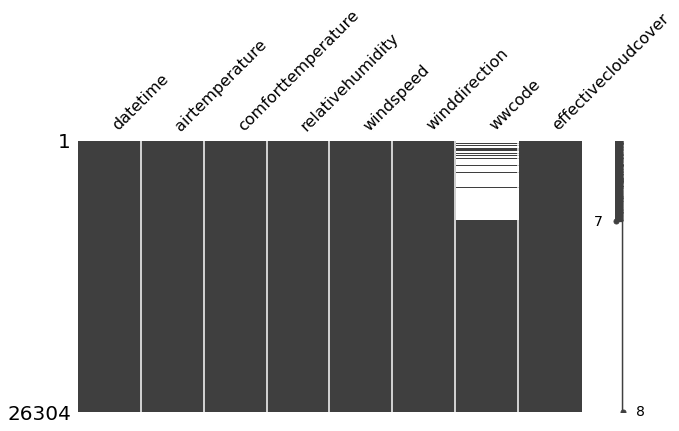

In [7]:
generation=pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=";")
temperature=pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=";")
# -----------------------------------------------------------------------------------------------------------------------
# generation
generation.DateTime=pd.to_datetime(generation.DateTime)
generation.Generation=generation.Generation.map(lambda x  : x.replace(',','.') if pd.notna(x) else x)
generation.Generation=generation.Generation.astype(float)
generation.columns=generation.columns.str.lower()
generation=generation.dropna()
generation.datetime.min() ,generation.datetime.max()

#temperature
temperature=pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=";")
temperature=temperature.applymap(lambda x : x.replace(',','.') if isinstance(x,str) else x)
temperature=temperature.astype({'ComfortTemperature':float,
                               'RelativeHumidity':float,
                               'AirTemperature' :float,
                               'WindSpeed':float,
                               'EffectiveCloudCover':float,
                               'WWCode':object
                               })
temperature.DateTime=pd.to_datetime(temperature.DateTime)
temperature.columns=temperature.columns.str.lower()
temperature=temperature.dropna(subset=['datetime'])
msno.matrix(temperature,figsize=(10, 5))

# External source data 

In [8]:
# getting  hourly data from external source for Ankara
from meteostat import Stations, Daily,Point,Hourly,Monthly,Normals
# Set time period
start = datetime(2019, 1, 1)
end = datetime(2022, 12, 31)
# Create Point for Vancouver, Ankara
vancouver = Point( 39.925533, 32.866287)
# Get Hourly data since 2019
df_hourly = Hourly(vancouver, start, end)
df_hourly = df_hourly.fetch()
# --------------------------------------------------------
df_hourly=df_hourly.reset_index().rename(columns={'time':'datetime'})
df_hourly.drop(['snow','tsun','dwpt','prcp'],axis=1,inplace=True)
df_hourly.coco=df_hourly.coco.astype(object)
df_hourly

datetime  temp  rhum   wdir  wspd  wpgt    pres coco
0     2019-01-01 00:00:00  -1.5  69.0   80.0  13.0  11.1  1028.1  4.0
1     2019-01-01 01:00:00  -1.0  69.0   70.0  14.8  11.1  1023.0  3.0
2     2019-01-01 02:00:00  -1.0  69.0   70.0  14.8  13.0  1022.0  5.0
3     2019-01-01 03:00:00  -1.5  73.0   80.0  11.2  11.1  1027.2  3.0
4     2019-01-01 04:00:00  -2.0  80.0   70.0  14.8  13.0  1022.0  4.0
...                   ...   ...   ...    ...   ...   ...     ...  ...
26299 2021-12-31 19:00:00   2.4  79.0  170.0   6.8   7.4  1020.8  2.0
26300 2021-12-31 20:00:00   2.3  80.0  183.0   7.2   7.4  1020.5  2.0
26301 2021-12-31 21:00:00   3.0  77.0  207.0   4.3   9.3  1020.3  2.0
26302 2021-12-31 22:00:00   3.1  78.0  240.0   3.6   7.4  1020.3  1.0
26303 2021-12-31 23:00:00   1.6  83.0  201.0   7.6   7.4  1020.2  1.0

[26304 rows x 8 columns]

In [9]:
# Getting  monthly data from external source for Ankara
# The reason  why we get monthly data 'tsun' feature get 'nan'  value in hourly data. But there is not a problem with monthly data
df_monthly = Monthly(vancouver, start, end)
df_monthly = df_monthly.fetch()
df_monthly=df_monthly['tsun']
df_monthly=df_monthly.reset_index()
df_monthly=df_monthly.rename(columns={'time':'datetime'})
df_monthly.datetime=pd.to_datetime(df_monthly.datetime)
df_monthly['month']=df_monthly.datetime.dt.month
df_monthly['year']=df_monthly.datetime.dt.year
df_monthly.drop('datetime',axis=1,inplace=True)
dum=df_monthly.groupby('month')['tsun'].mean().to_frame()
df_monthly.tsun=df_monthly.apply(lambda x: dum.loc[x.month].values[0] if pd.isna(x.tsun) else x.tsun,axis=1)
df_monthly=df_monthly[:-1]
df_monthly.head()

tsun  month  year
0   2100.0      1  2019
1   4500.0      2  2019
2   9240.0      3  2019
3  10830.0      4  2019
4  14220.0      5  2019

In [10]:
# in here again we getting data by means of another library
# from wwo_hist import retrieve_hist_data
# pip install wwo-hist
# FREQUENCY = 1
# START_DATE = '01-JAN-2019'
# END_DATE = '31-DEC-2021'
# API_KEY = '362b2c52cb7f4c49aaa84930222102'
# LOCATION_LIST = ['Ankara']

# df_new = retrieve_hist_data(API_KEY,
#                                 LOCATION_LIST,
#                                 START_DATE,
#                                 END_DATE,
#                                 FREQUENCY,
#                                 location_label = False,
#                                 export_csv = True,
#                                 store_df = True)


In [11]:
#I got hourly weather data for Ankara then ı saved and the ı load to my kaggle data.
#The  reason this do ı don't want to, again  and again, download hourly Ankara weather data using the library.
#Code avobe
import datetime
df_new=pd.read_csv('/kaggle/input/ankaraweatherdata/Ankara.csv')
df_new=df_new.rename(columns={'date_time':'datetime'})
df_new.datetime=pd.to_datetime(df_new.datetime)
df_new.sunrise=pd.to_datetime(df_new.sunrise).dt.time
df_new.sunset=pd.to_datetime(df_new.sunset).dt.time
df_new.sunrise=df_new.sunrise.map(lambda x: int(datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds())/60) # sunrise time converted  in minutes for example time 5 am 5*60=300 minute 
df_new.sunset=df_new.sunset.map(lambda x: int(datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds())/60)   # sunset time converted  in minutes for example time 6 am  18*60=1080 minute
df_new['srise-sset']=df_new.sunset-df_new.sunrise

df_ankara=df_new.loc[:,['datetime','sunset','sunrise','srise-sset','sunHour','uvIndex','visibility','cloudcover','pressure','WindChillC']]

# Feature Engineering

In [12]:
data=temperature.merge(generation, how='left',on='datetime')
# --------------------------------------------------------------------------------------------------------
data['year']=data.datetime.dt.year.astype(object)
data['dayofmonth']=data.datetime.dt.day.astype(object)
data['hour']=data.datetime.dt.hour.astype(object)
data['dayofyear']=data.datetime.dt.dayofyear
data['month']=data.datetime.dt.month

# ---------------------------------------------------------------------------------------------------------
# some encode operations so that the model can generalize.
data['date']=data.datetime.dt.date
data['wntr_month']=data.apply(lambda x: 1 if x.month in ([11,12,1,2]) else 0,axis=1) #we encode the winter month 
data['wntr_month']=data['wntr_month'].astype(object)
data['hour_label']=pd.cut(data.hour,bins=[0,5,10,15,20,24], labels=[0,1,2,3,0],ordered=False,right=False)
data['month_label']=data.month.map(lambda x : '1' if x in ([11,12,1,2,3]) else ( '2' if x in ([6,7,8,9]) else '3' ))
# --------------------------------------------------------------------------------------------------------

#Functions
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

encode(data, 'dayofyear', 365)
encode(data, 'month', 12)

data["solar_irradiance"] = (1+0.033*np.cos(2*np.pi*data["dayofyear"]/365))
data["RelativeHumidity_r3mean"] = data["relativehumidity"].rolling(3).mean()
data["AirTemperature_r3mean"] = data["airtemperature"].rolling(3).mean()

data.drop(['dayofyear'],inplace=True,axis=1)
data['month']=data['month'].astype(object)
# --------------------------------------------------------------------------------------------------------
dum=data.wwcode.value_counts()[data.wwcode.value_counts()<10].index
data.wwcode=data.wwcode.map(lambda x:  0 if x  in (dum) else x)
data.wwcode=data.wwcode.fillna(0)
data['wwcode']=data['wwcode'].astype(object)
# --------------------------------------------------------------------------------------------------------
# external data has merging with  main dataframe
data=data.merge(df_hourly,how='left',on='datetime')
data=data.merge(df_monthly,how='left',on=['year','month'])
data=data.merge(df_ankara,how='left',on='datetime')

In [13]:
# in here we calculate the mean  of  generation   separately  by month, year ,day ,and hour 
dum1=data.groupby(['month','hour'])['generation'].mean().reset_index().rename(columns={'generation':'avg_month_hour_gen'})
data=data.merge(dum1,how='left',on=['month','hour'])
# ------------------------------------------------------------------------------------------------------------------------
dum2=data.groupby(['month','dayofmonth'])['generation'].mean().reset_index().rename(columns={'generation':'avg_month_day_gen'})
data=data.merge(dum2,how='left',on=['month','dayofmonth'])
# -----------------------------------------------------------------------------------------------------------------------
dum3=data.groupby('month')['generation'].mean().reset_index().rename(columns={'generation':'avg_month_gen'})
data=data.merge(dum3,how='left',on='month')
# ---------------------------------------------------------------------------------------------------------------------
dum4=data.groupby('year').generation.mean().reset_index().rename(columns={'generation':'gen_year_mean'})
data=data.merge(dum4,how='left',on='year')
# ---------------------------------------------------------------------------------------------------------------------
data.coco=data.coco.map(lambda x: 0  if x in [13,19,23,8,6] else x)
# ---------------------------------------------------------------------------------------------------------------------
dum5=data.groupby('visibility').generation.mean().reset_index().rename(columns={'generation':'gen_visibility_mean'})
data=data.merge(dum5,how='left',on='visibility').set_index(data.index)
dum6=data.groupby('uvIndex').generation.mean().reset_index().rename(columns={'generation':'gen_uvIndex_mean'})
data=data.merge(dum6,how='left',on='uvIndex').set_index(data.index)
# ---------------------------------------------------------------------------------------------------------------------
#the number of sunny days by month from external source 
ex_data=pd.DataFrame({ 'month':range(1,13),
                'güneşli':[2.6,3.8,5.1,6.6,8.4,10.1,11.3,10.8,9.2,6.72,4.6,2.6],
                'günesşiz_gün':[14.7,13.2,14.3,14.5,16.1,11.4,5.6,4.5,5.6,9.0,10.6,14.5]})
data=data.merge(ex_data ,how='left', on='month')

In [14]:
# we have a tsun feature that feature is monthly data. in here first we divided monthly data to 30 and 
# then daily tsun feature assume normally distributed and then multiply a normal distribution .
norm=np.linalg.norm([0,0,0,0,0,1,2,3,4,5,6,7,7,6,5,4,3,2,1,0,0,0,0,0])
norm=np.array([0,0,0,0,0,1,2,3,4,5,6,7,7,6,5,4,3,2,1,0,0,0,0,0])/norm
dum=(data.groupby(['year','month','dayofmonth'])['tsun'].first()/30).to_frame().applymap(lambda x: x*norm).explode('tsun')
data['tsun2']=dum.tsun.values
data['tsun2']=data['tsun2'].astype(float)

In [15]:
for i in list(range(1,8)):
    for col in ["effectivecloudcover",
                "relativehumidity",
                "airtemperature", 
                "airtemperature",
                "wwcode",
                'coco'
               ]:
        data[col+str(i)] = data[col].shift(-i)

In [16]:
data.iloc[:,20:40]

month_cos  solar_irradiance  RelativeHumidity_r3mean  \
0       0.866025          1.032995                      NaN   
1       0.866025          1.032995                      NaN   
2       0.866025          1.032995                75.100000   
3       0.866025          1.032995                75.466667   
4       0.866025          1.032995                75.833333   
...          ...               ...                      ...   
26299   1.000000          1.033000                55.233333   
26300   1.000000          1.033000                61.300000   
26301   1.000000          1.033000                66.000000   
26302   1.000000          1.033000                70.333333   
26303   1.000000          1.033000                74.066667   

       AirTemperature_r3mean  temp  rhum   wdir  wspd  wpgt    pres  coco  \
0                        NaN  -1.5  69.0   80.0  13.0  11.1  1028.1   4.0   
1                        NaN  -1.0  69.0   70.0  14.8  11.1  1023.0   3.0   
2                  -1.833333  -1.0  69.0   70.0  14.8  13.0  1022.0   5.0   
3                  -1.900000  -1.5  73.0   80.0  11.2  11.1  1027.2   3.0   
4                  -1.966667  -2.0  80.0   70.0  14.8  13.0  1022.0   4.0   
...                      ...   ...   ...    ...   ...   ...     ...   ...   
26299              10.033333   2.4  79.0  170.0   6.8   7.4  1020.8   2.0   
26300               9.033333   2.3  80.0  183.0   7.2   7.4  1020.5   2.0   
26301               8.066667   3.0  77.0  207.0   4.3   9.3  1020.3   2.0   
26302               7.166667   3.1  78.0  240.0   3.6   7.4  1020.3   1.0   
26303               6.300000   1.6  83.0  201.0   7.6   7.4  1020.2   1.0   

         tsun  sunset  sunrise  srise-sset  sunHour  uvIndex  visibility  \
0      2100.0  1054.0    490.0       564.0      8.7        2          10   
1      2100.0  1054.0    490.0       564.0      8.7        2          10   
2      2100.0  1054.0    490.0       564.0      8.7        2          10   
3      2100.0  1054.0    490.0       564.0      8.7        2          10   
4      2100.0  1054.0    490.0       564.0      8.7        2          10   
...       ...     ...      ...         ...      ...      ...         ...   
26299  6180.0  1054.0    490.0       564.0      8.7        3          10   
26300  6180.0  1054.0    490.0       564.0      8.7        3          10   
26301  6180.0  1054.0    490.0       564.0      8.7        3          10   
26302  6180.0  1054.0    490.0       564.0      8.7        3          10   
26303  6180.0  1054.0    490.0       564.0      8.7        3          10   

       cloudcover  pressure  
0              29      1029  
1              30      1029  
2              30      1028  
3              31      1028  
4              36      1028  
...           ...       ...  
26299           4      1021  
26300           5      1021  
26301           5      1021  
26302          12      1022  
26303          18      1022  

[26304 rows x 20 columns]

In [17]:
# I made  5 clusters for  generation feature and labeled
from sklearn.cluster import KMeans
dum=data[['datetime','generation']].set_index('datetime').dropna()
kmean=KMeans(n_clusters=5)
kmean.fit(dum)
dum['gen_label']=kmean.labels_
dum['month']=dum.index.month
dum['dayofmonth']=dum.index.day
dum['hour']=dum.index.hour
dum.reset_index(drop=True,inplace=True)
dum.drop('generation',inplace=True,axis=1)
dum=dum.drop_duplicates()
dum.set_index(['month','dayofmonth','hour'],inplace=True)
data['generation_label']=data.apply(lambda x:  dum.loc[x.month,x.dayofmonth,x.hour].values[0][0],axis=1)
data['generation_label']=data['generation_label'].astype(object)

# Data visualization  

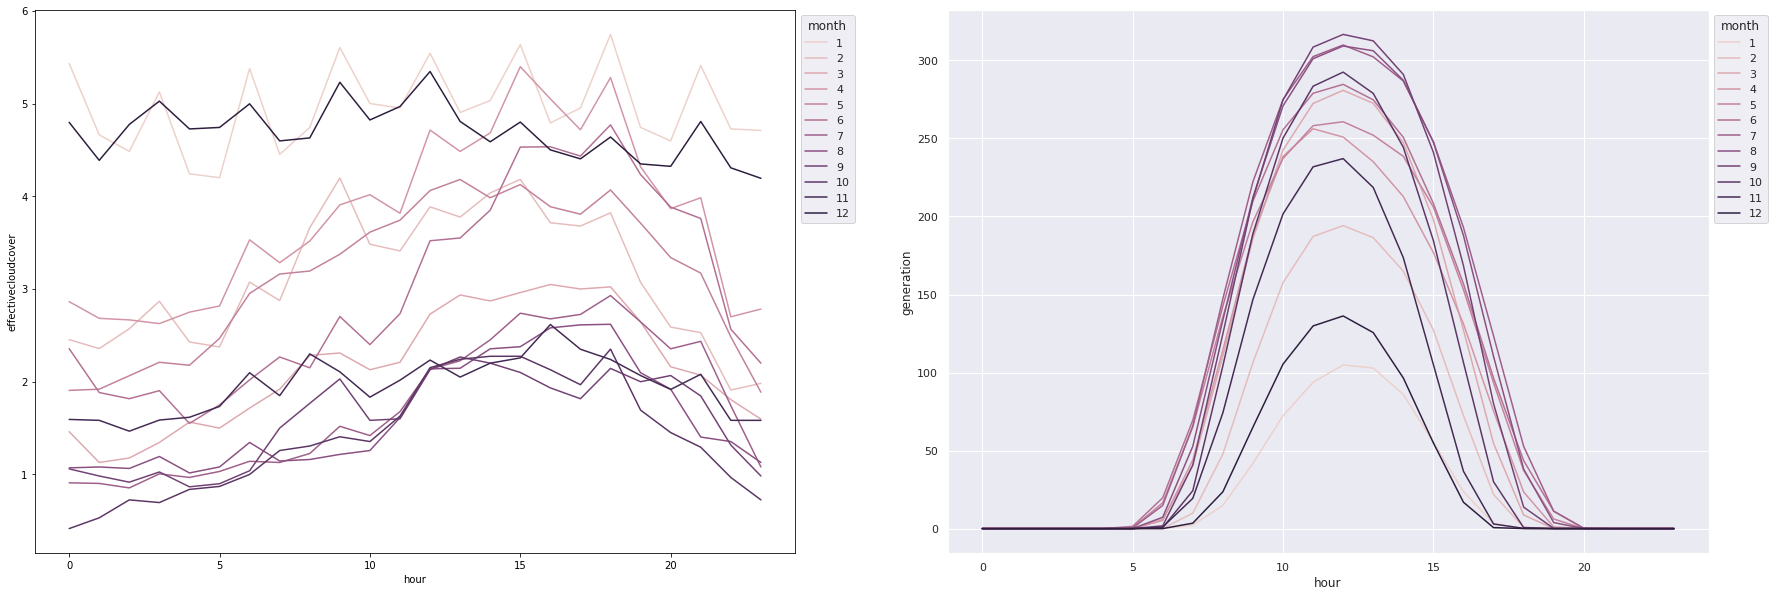

In [18]:
# hourly averages according to month for effectivecloudcover
dum=data[(data.year==2019)].groupby(['month','hour'])[['effectivecloudcover','generation']].mean().reset_index()
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.effectivecloudcover,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplot(1,2,2)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.generation,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

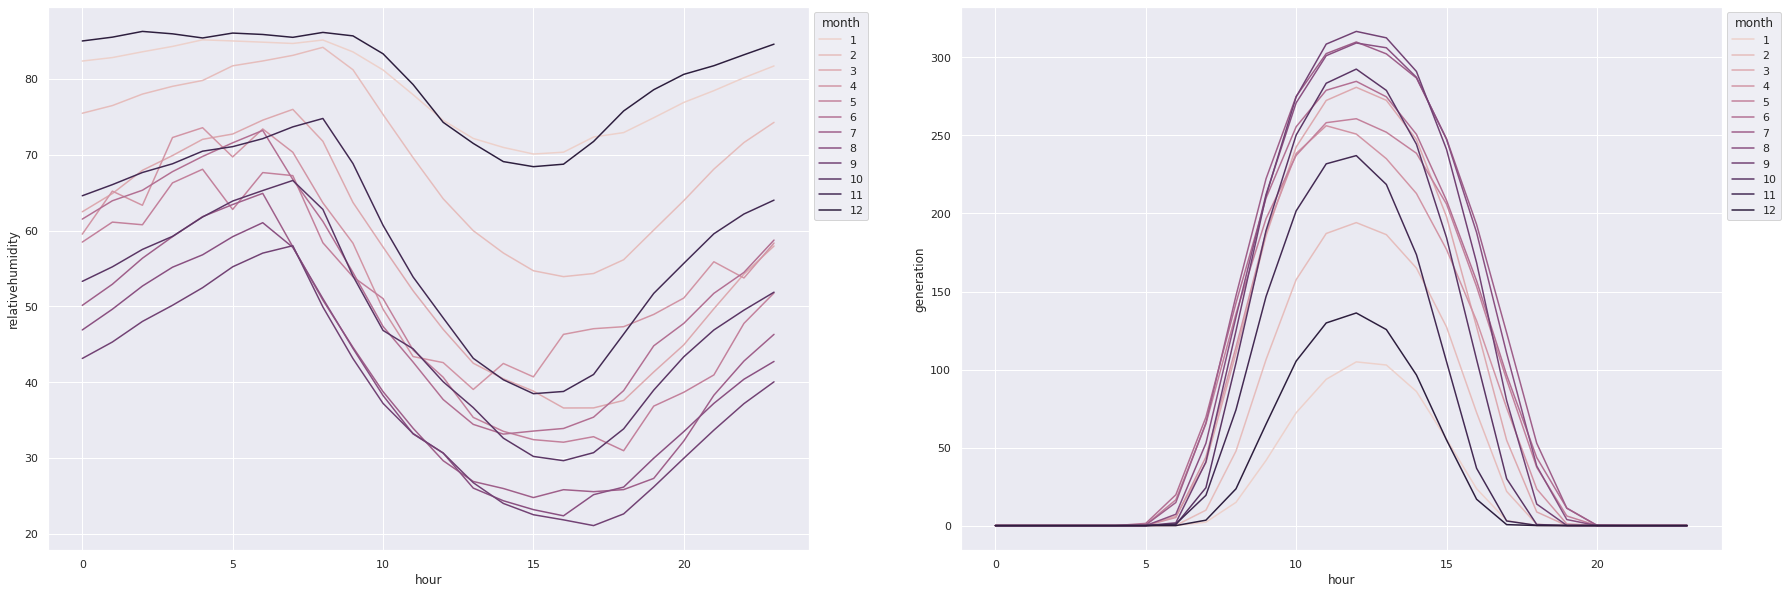

In [19]:
# hourly averages according to month for relativehumidity
dum=data[(data.year==2019)].groupby(['month','hour'])[['relativehumidity','generation']].mean().reset_index()
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.relativehumidity,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplot(1,2,2)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.generation,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

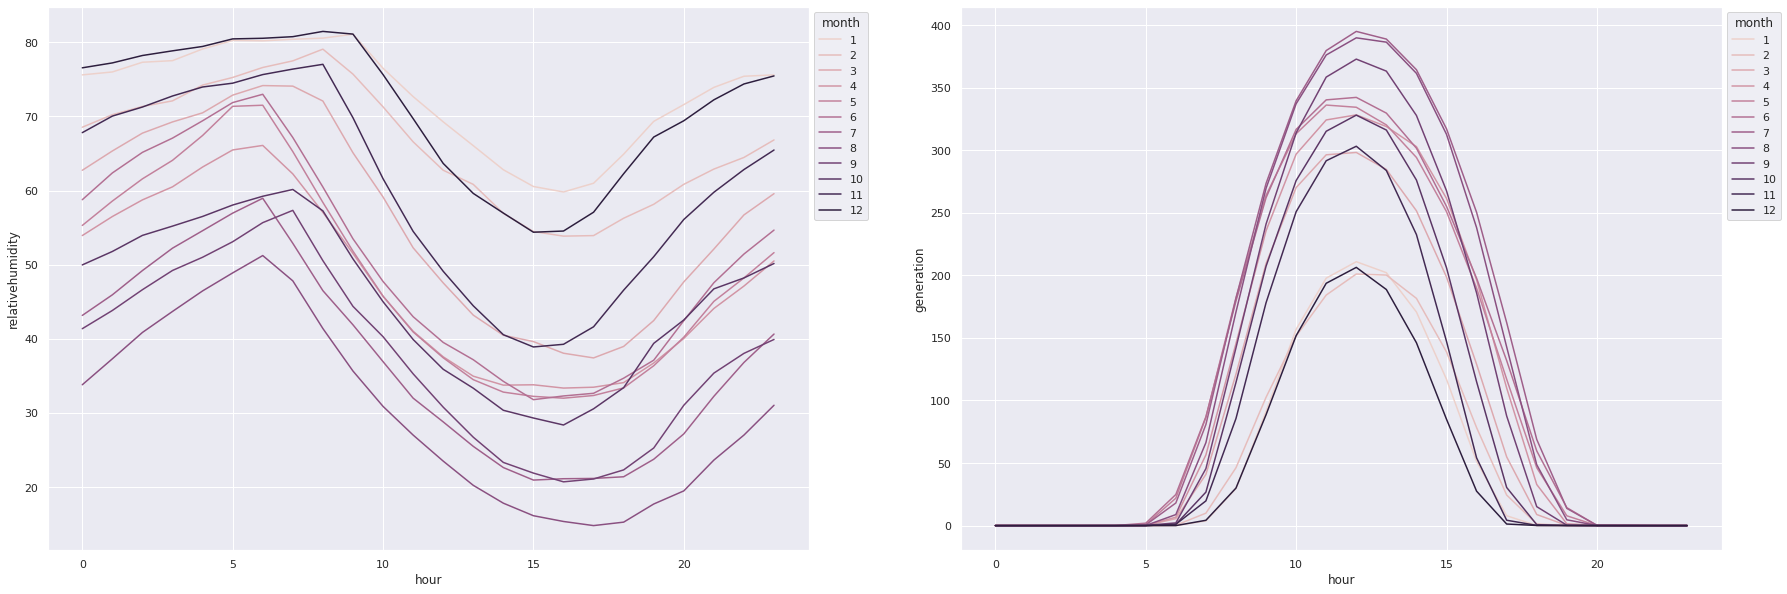

In [20]:
#hourly averages according to month for relativehumidity 
dum=data[(data.year==2020)].groupby(['month','hour'])[['relativehumidity','generation']].mean().reset_index()
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.relativehumidity,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplot(1,2,2)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.generation,hue=dum.month,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

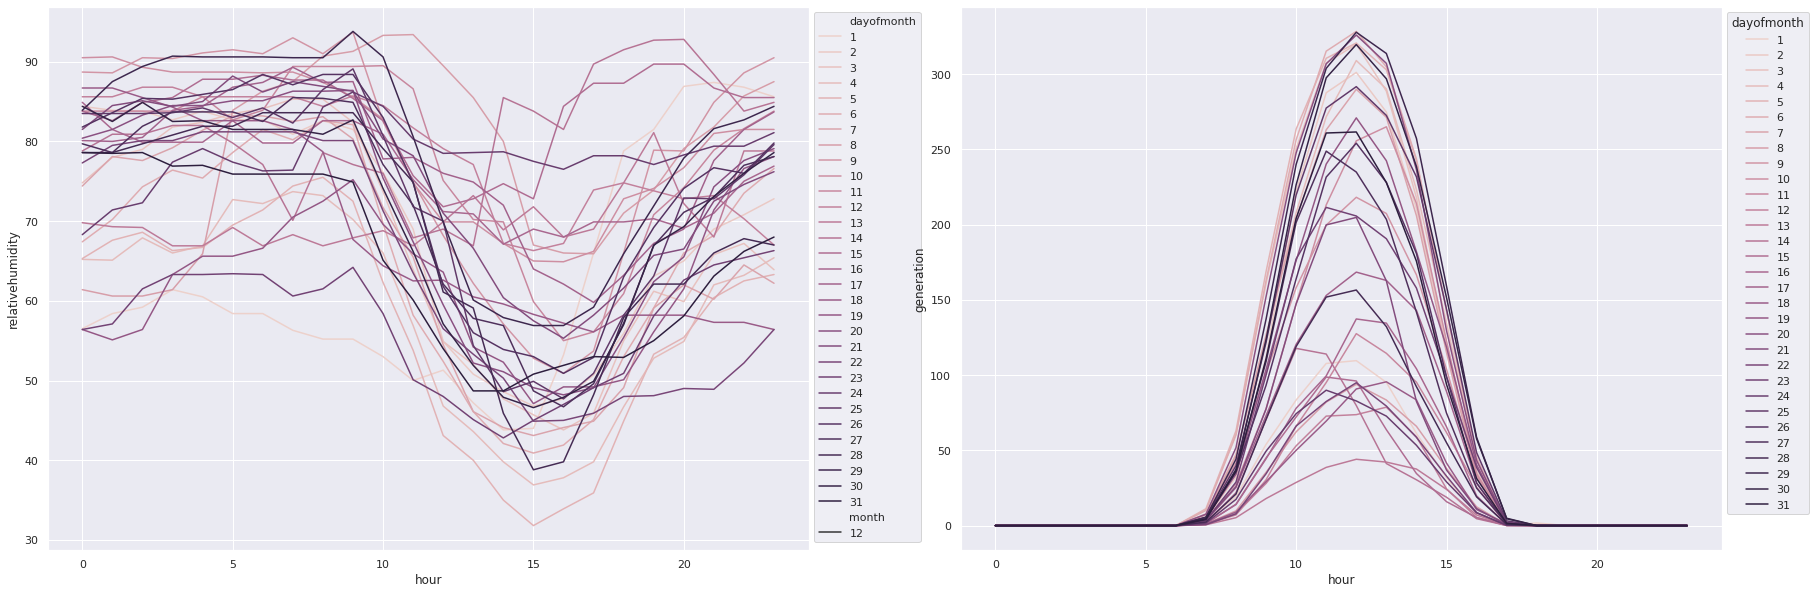

In [21]:
# hourly averages only of one day for relative humidity
dum=data[(data.year==2020)&(data.month==12)]
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.relativehumidity,hue=dum.dayofmonth,legend=all, style=dum.month)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplot(1,2,2)
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.generation,hue=dum.dayofmonth,legend=all)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

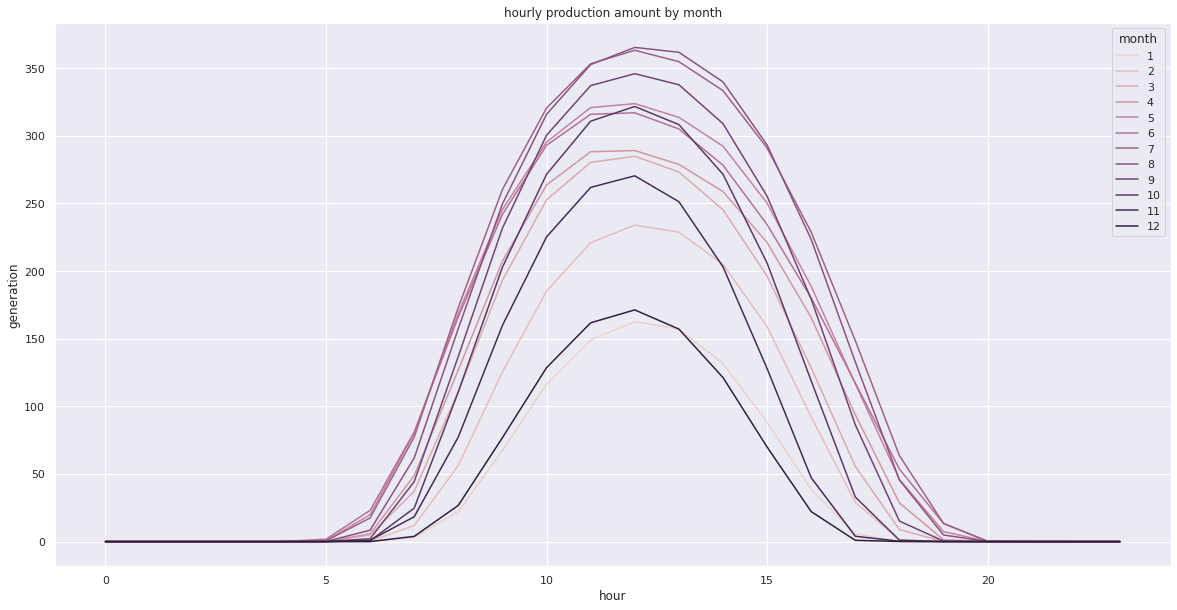

In [22]:
dum=data[data.generation.notnull()].groupby(['month','hour'])['generation'].mean().reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x='hour',y='generation',hue='month',data=dum,legend='full').set_title("hourly production amount by month");

In [23]:
line_data=data[data.generation.notnull()].groupby(['hour'])['generation'].mean().reset_index()
fig=go.Figure(data=go.Scatter(x=line_data.hour,y=line_data.generation,mode='markers',marker=dict(color='green')))
fig.update_layout(title='production amount', xaxis_title='hour', yaxis_title='energy production amount')
fig.show()

In [24]:
line_data=data[data.generation==0].groupby(['date'])['hour'].count().reset_index()
fig=go.Figure(data=go.Scatter(x=line_data.date,y=line_data.hour,mode='markers',marker=dict(color='green')))
fig.update_layout(title='total hours of no energy production during the day', xaxis_title='date', yaxis_title='time without energy production')
fig.show()

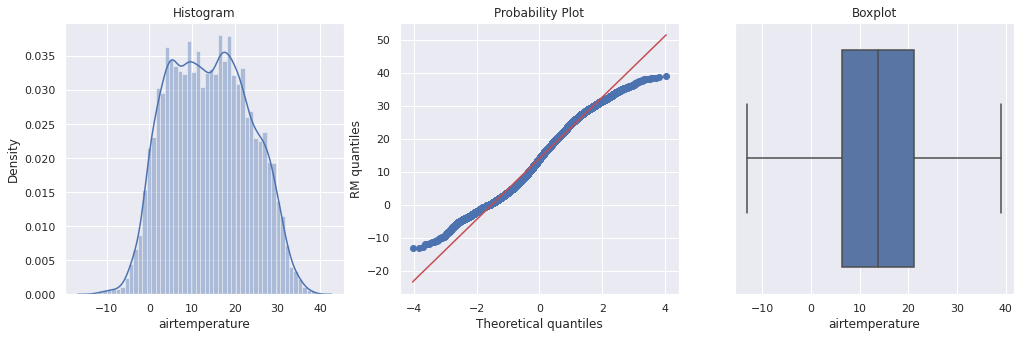

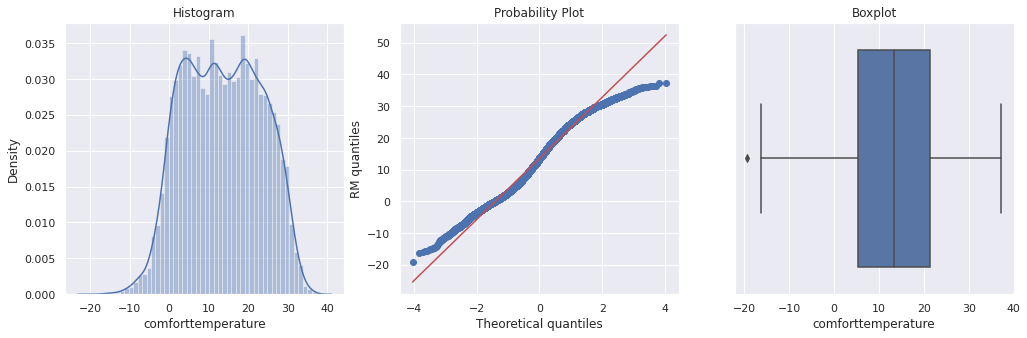

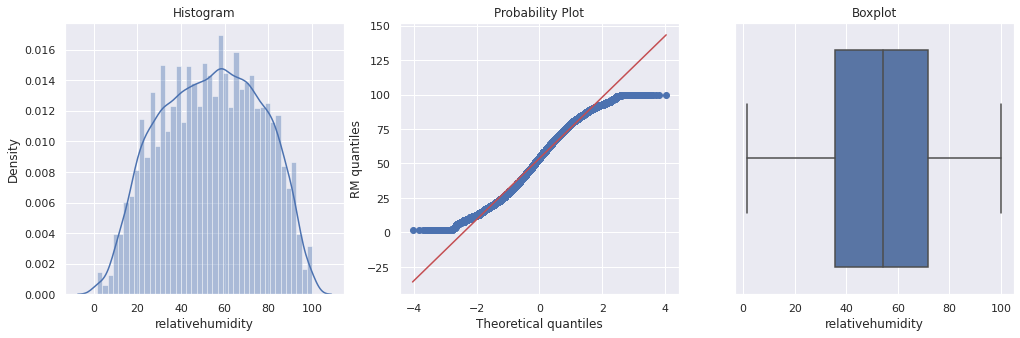

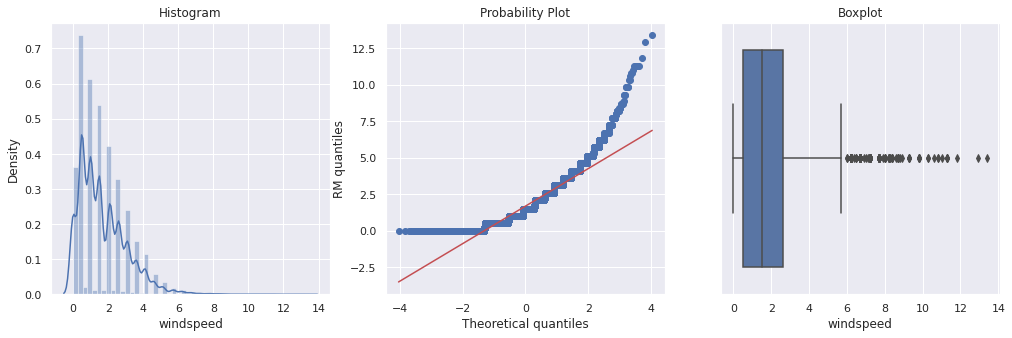

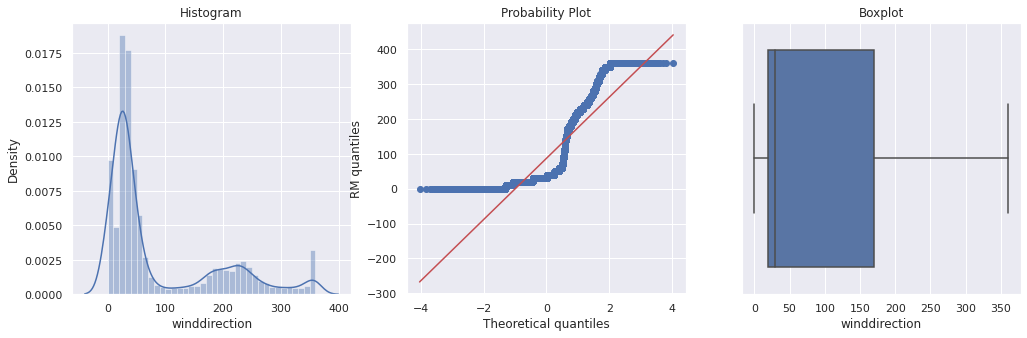

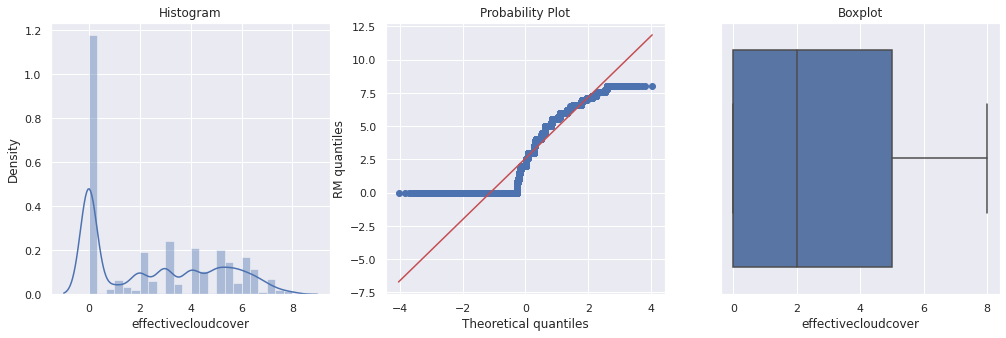

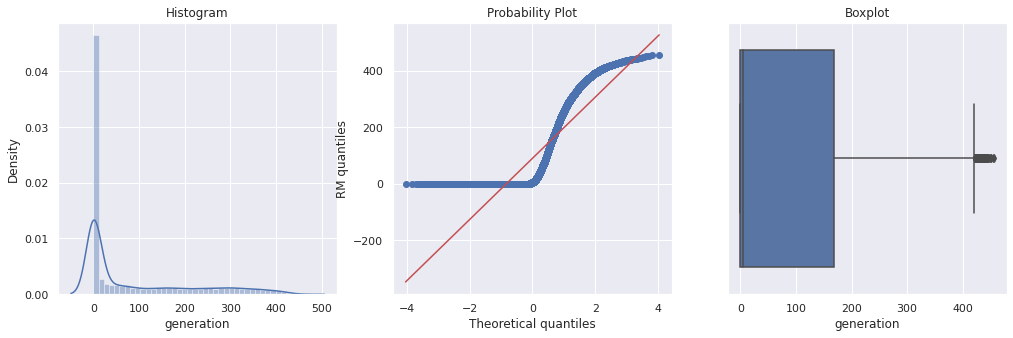

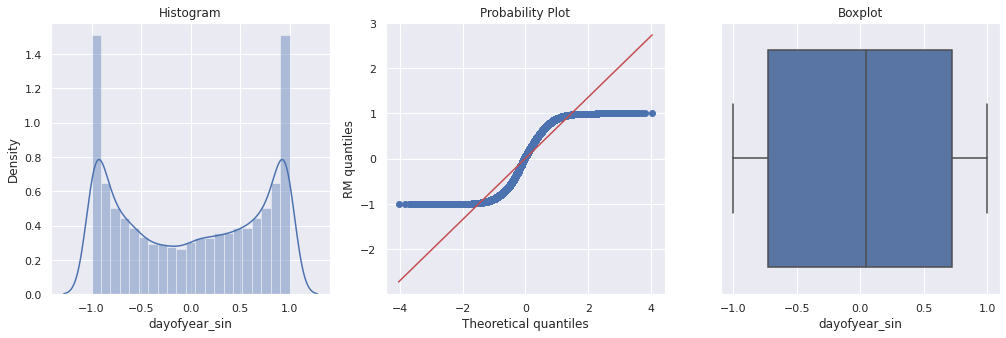

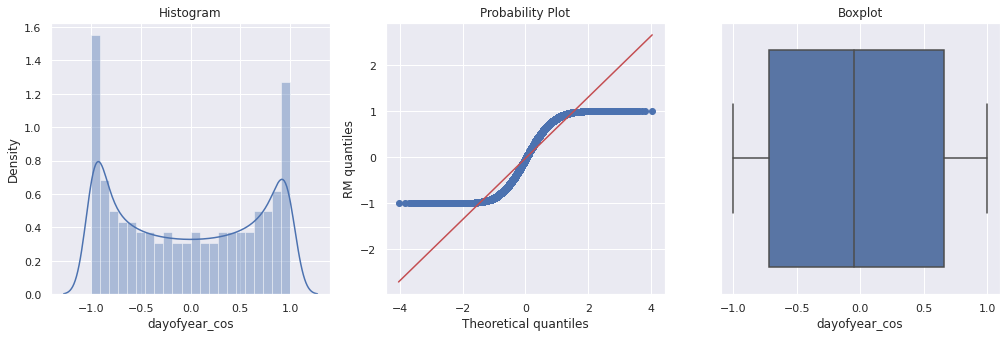

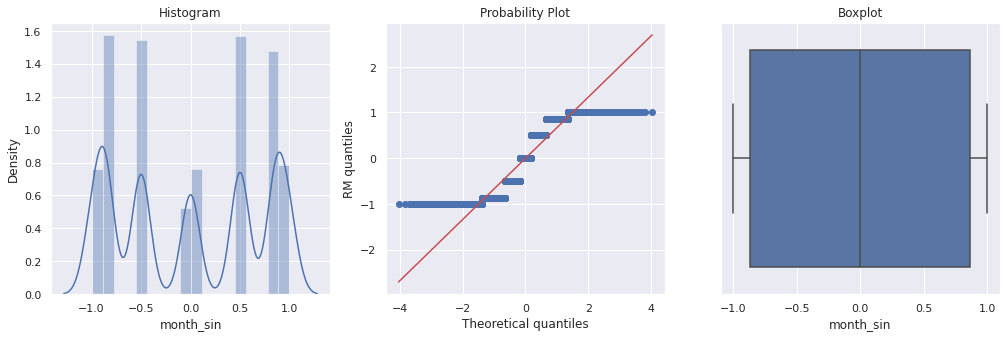

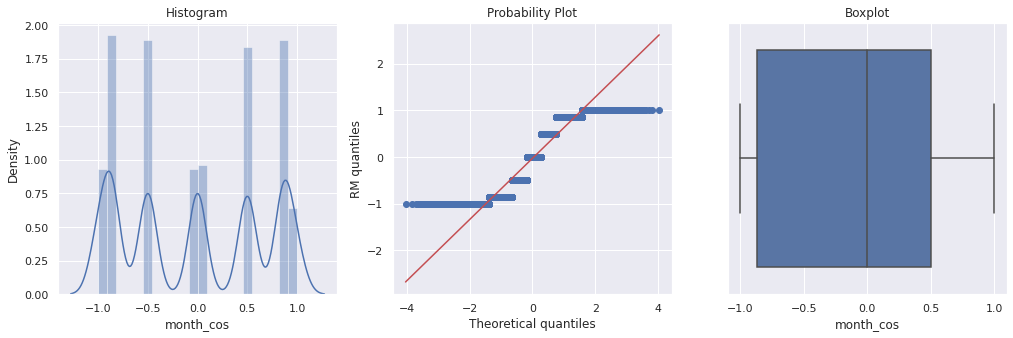

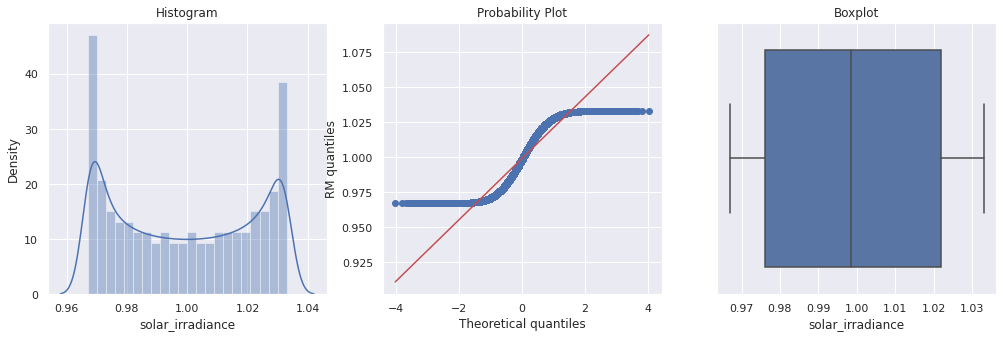

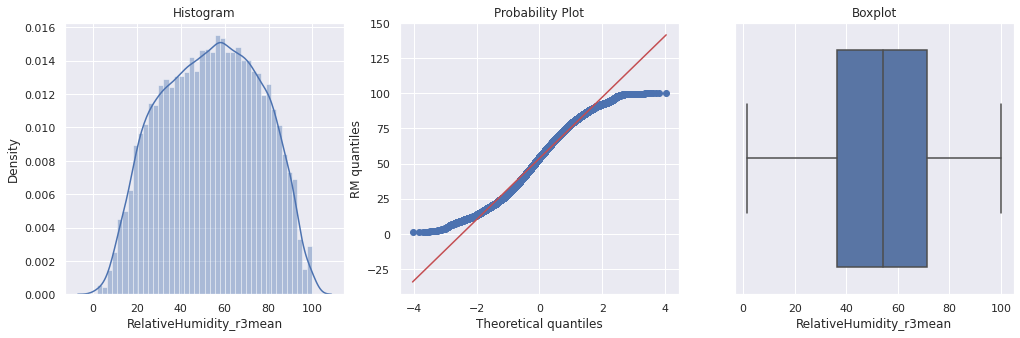

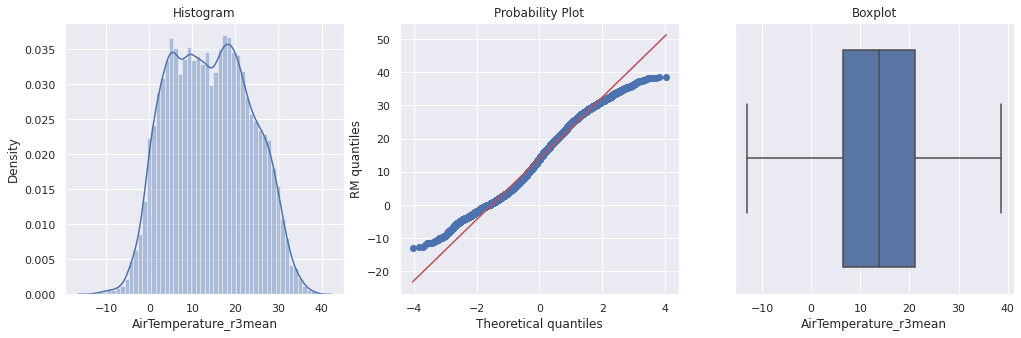

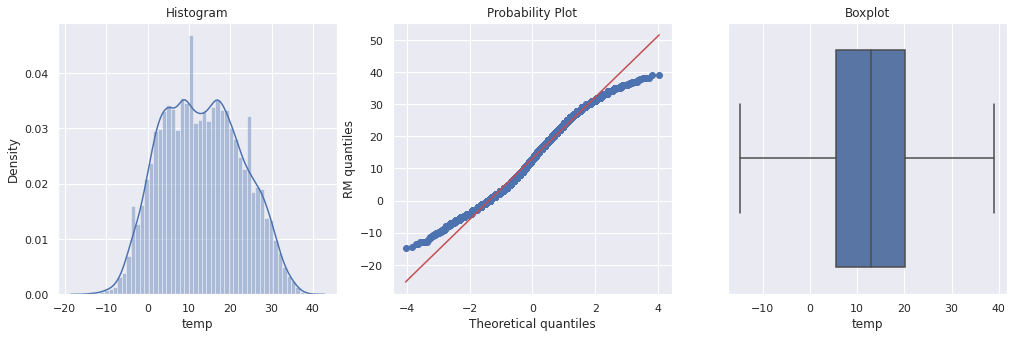

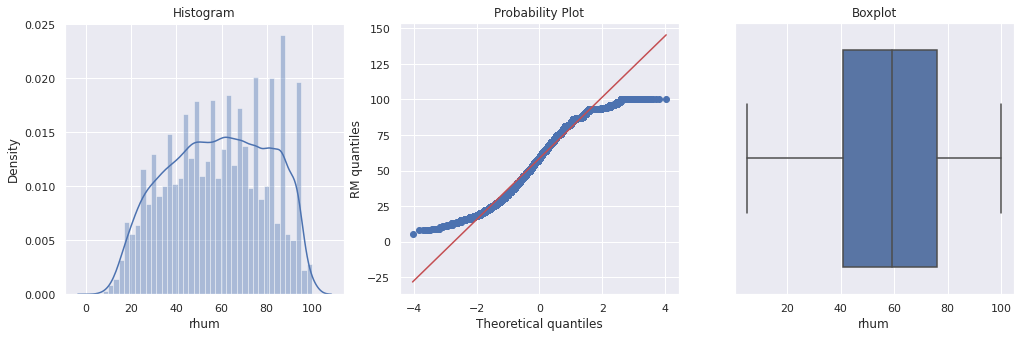

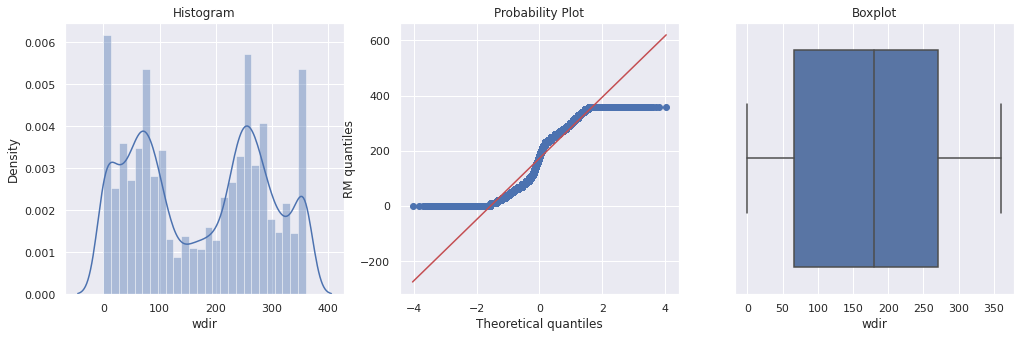

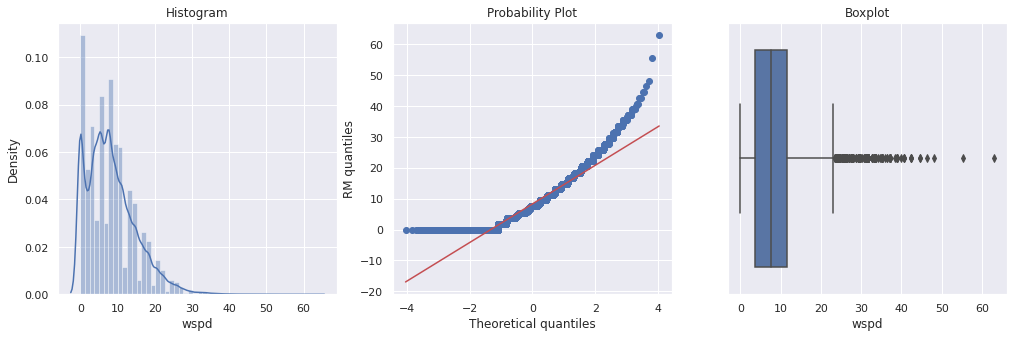

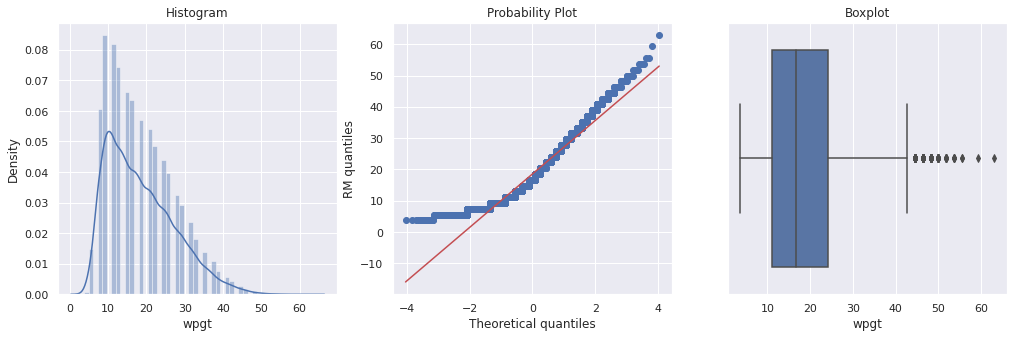

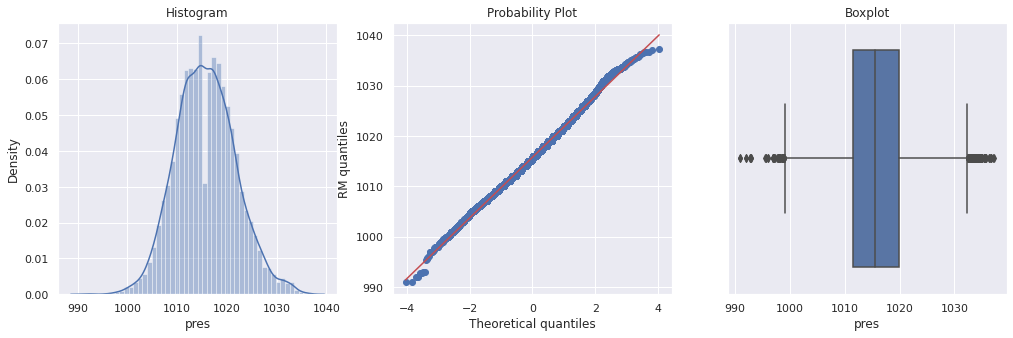

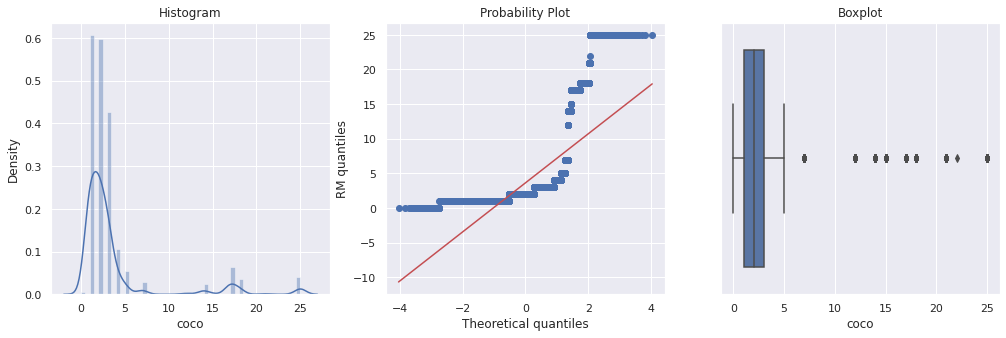

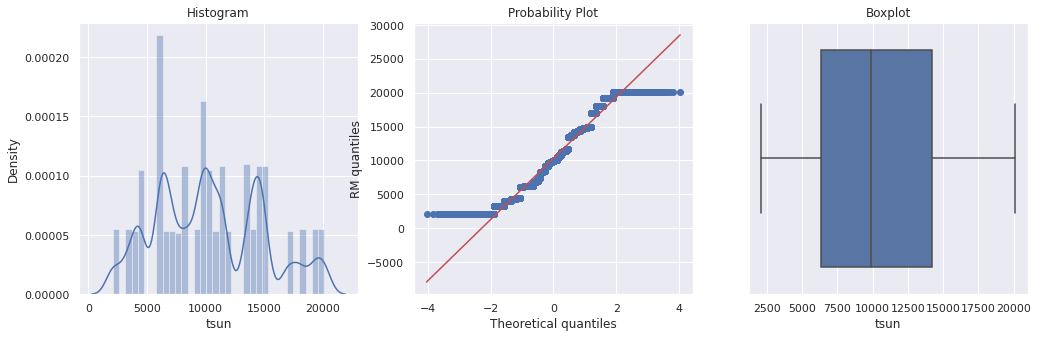

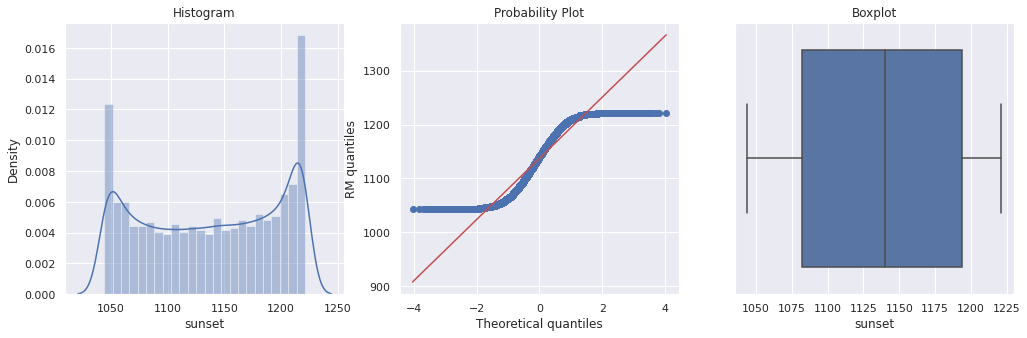

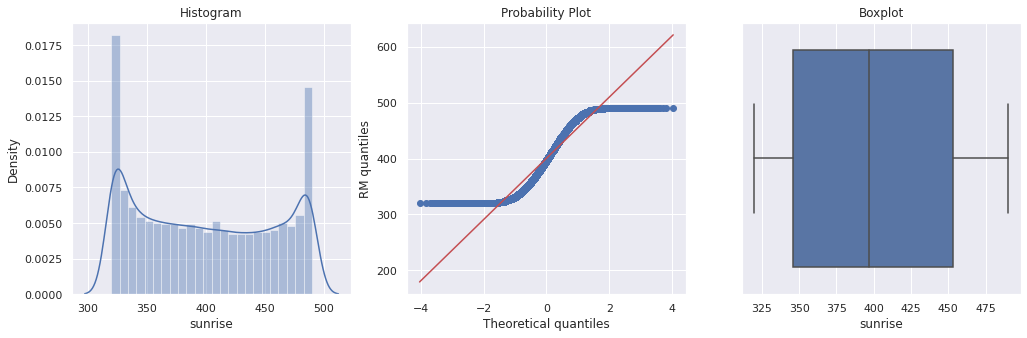

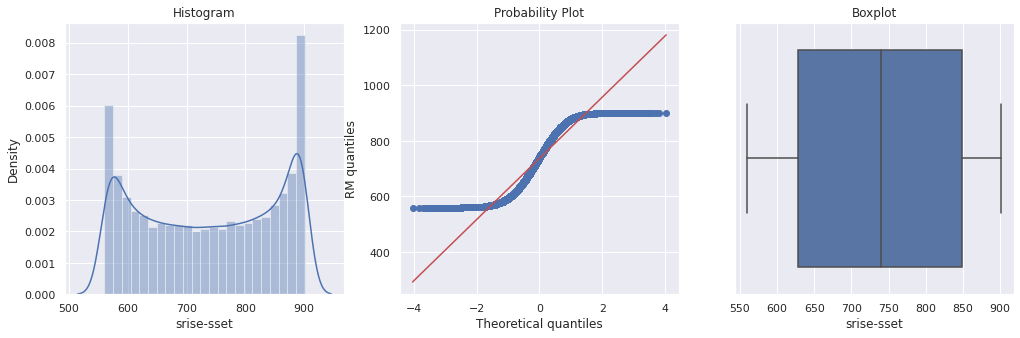

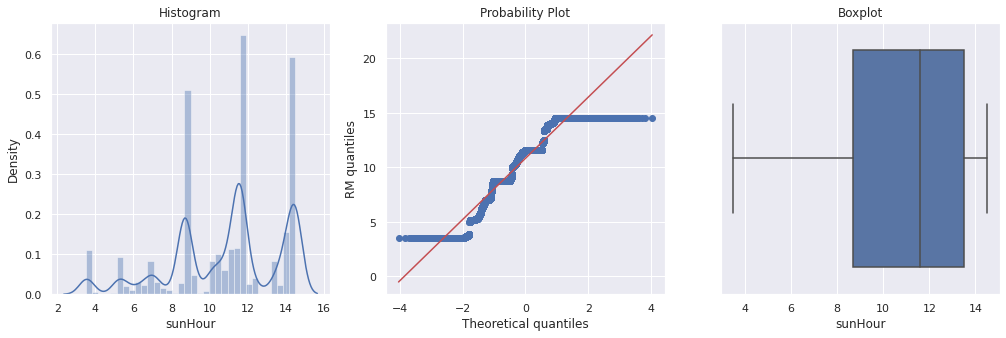

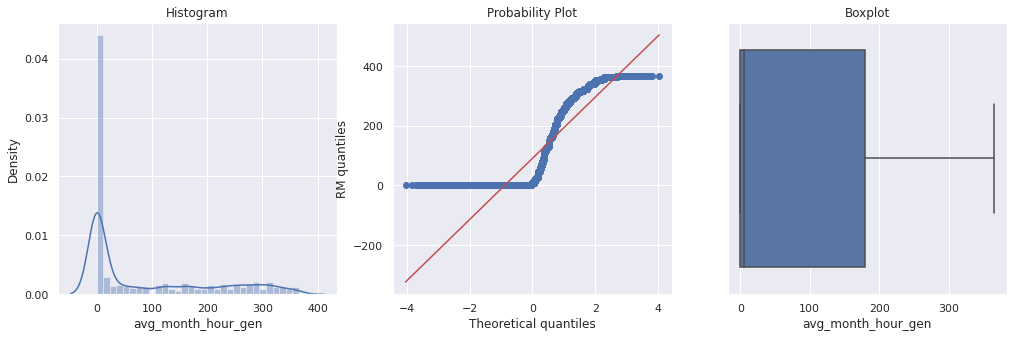

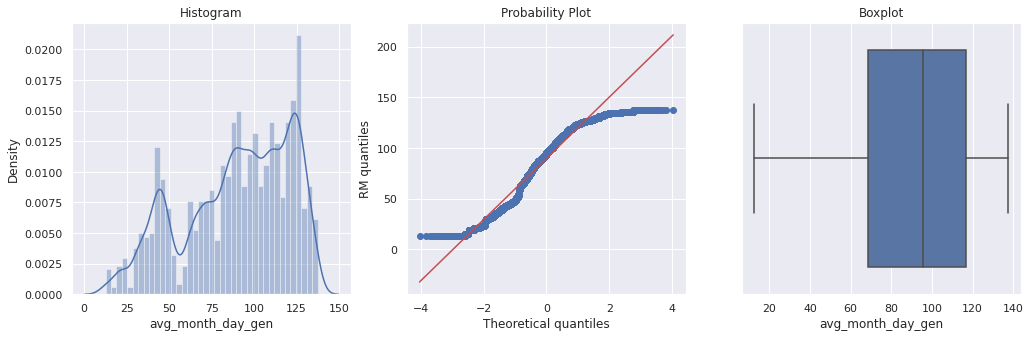

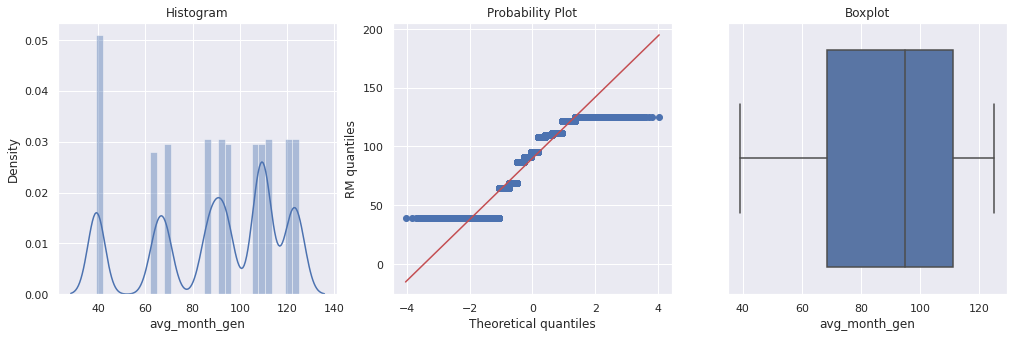

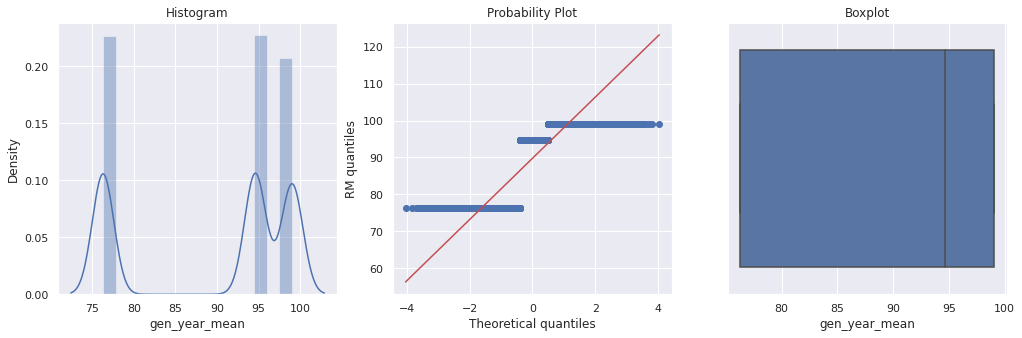

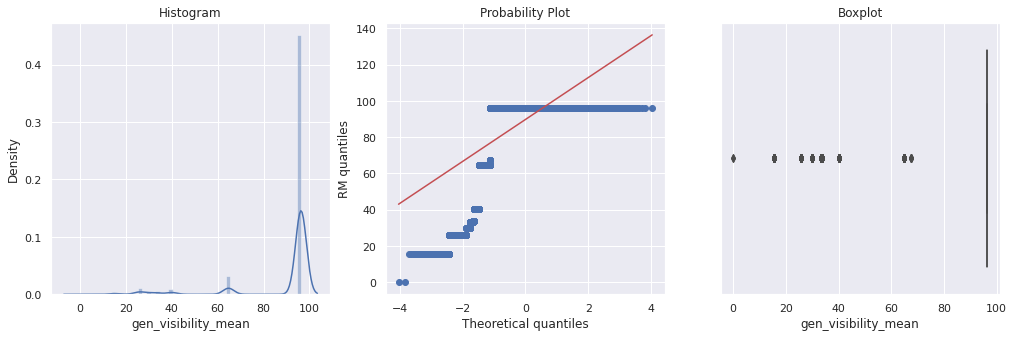

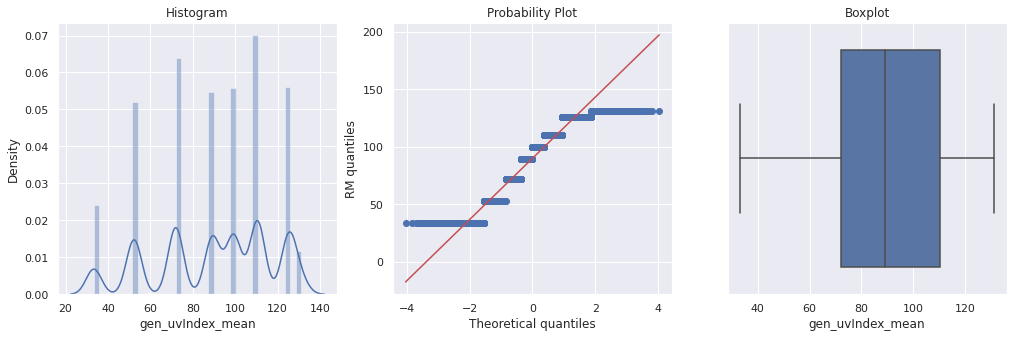

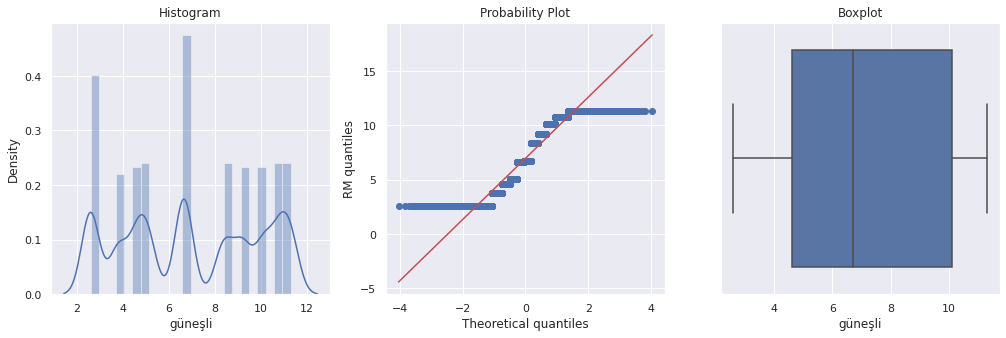

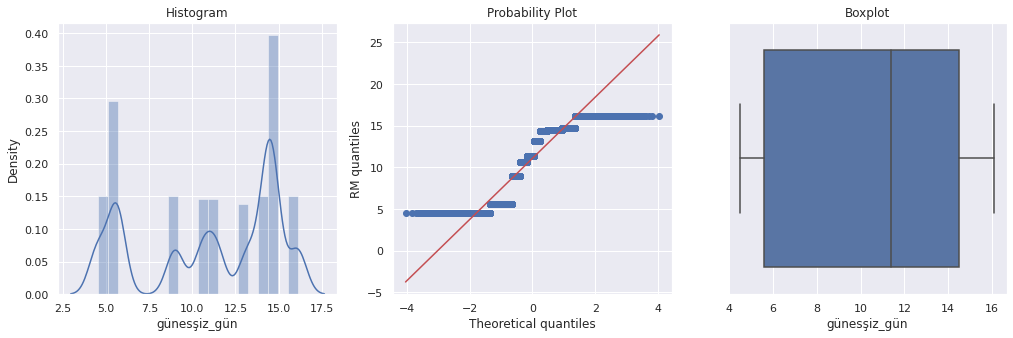

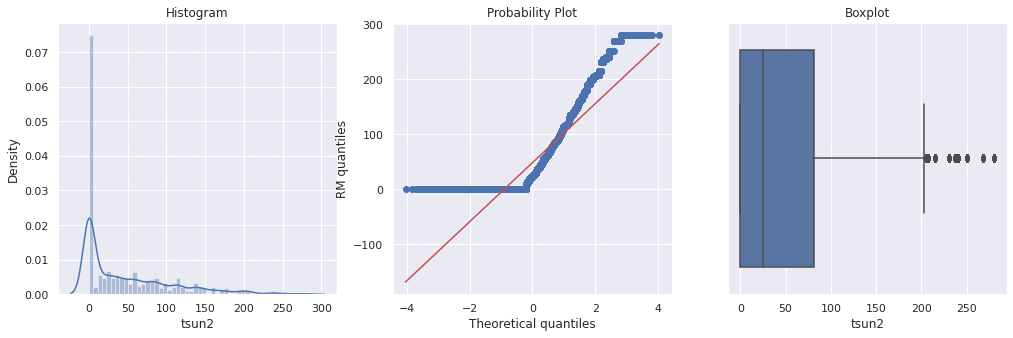

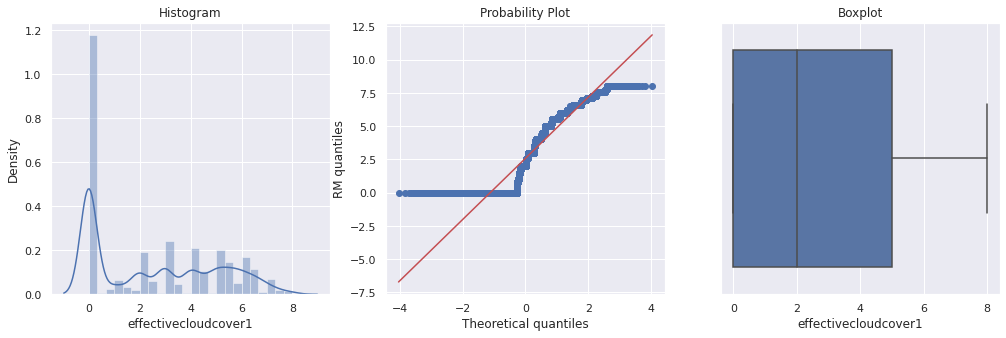

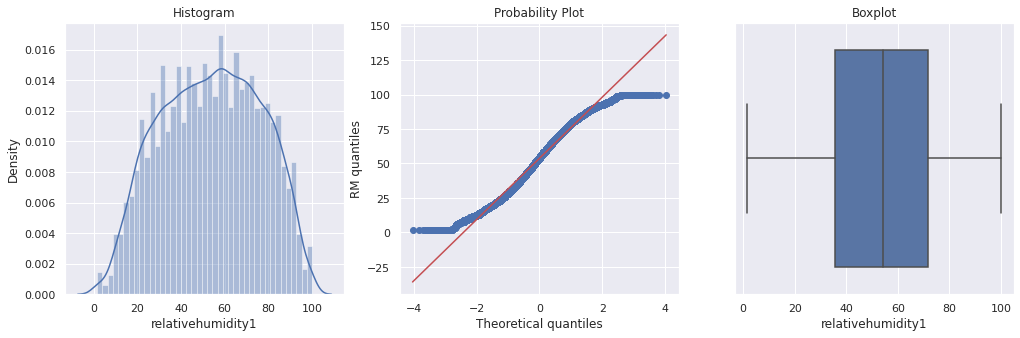

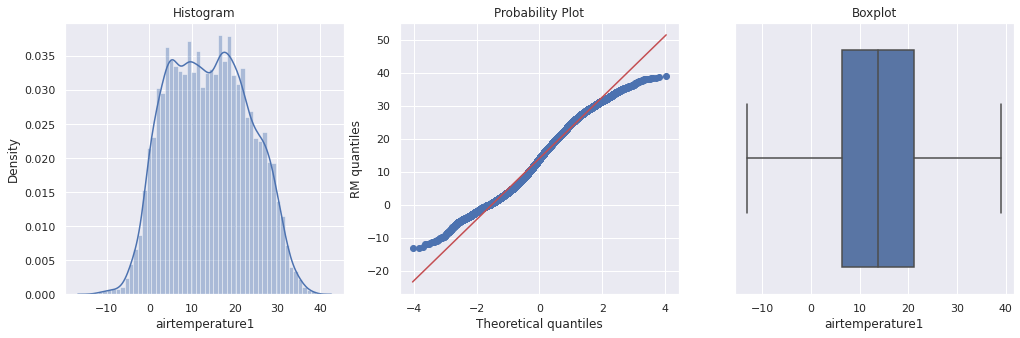

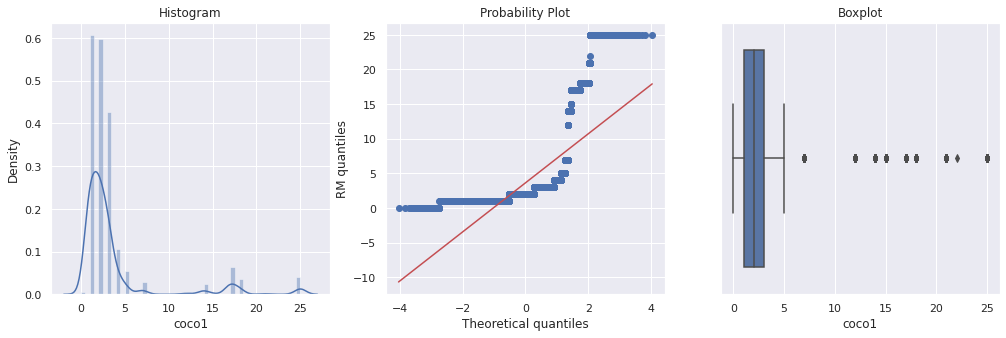

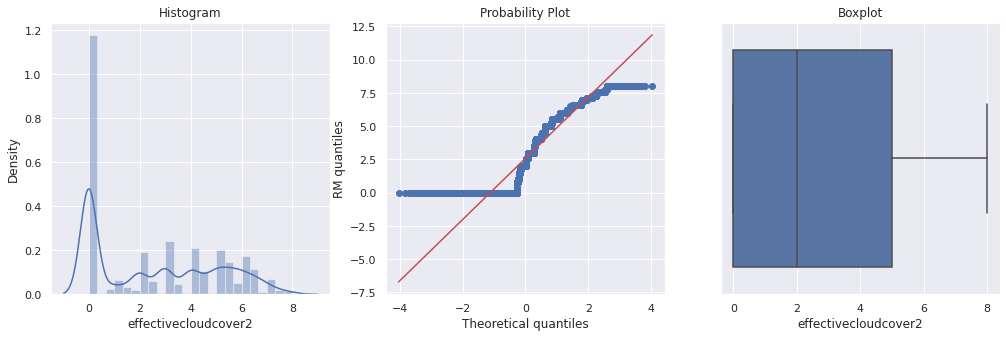

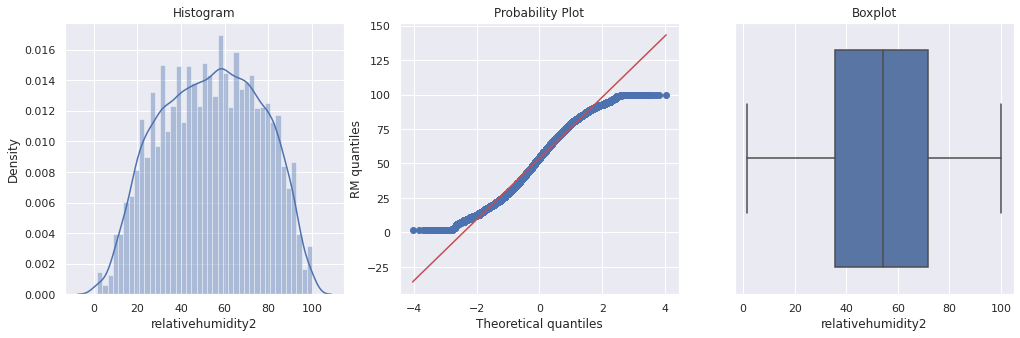

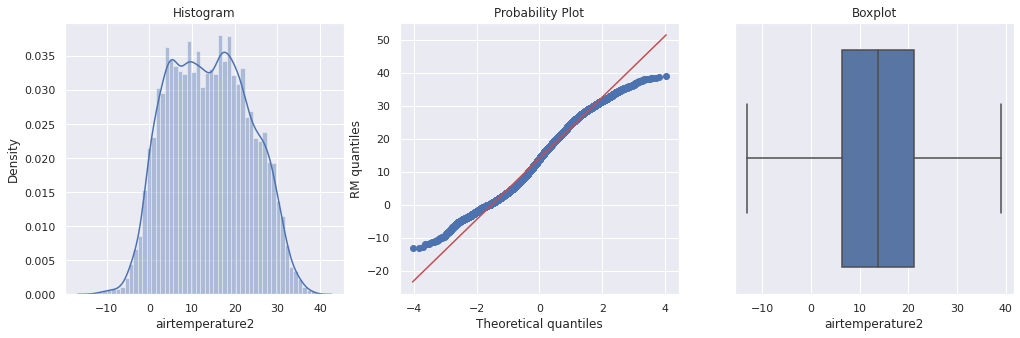

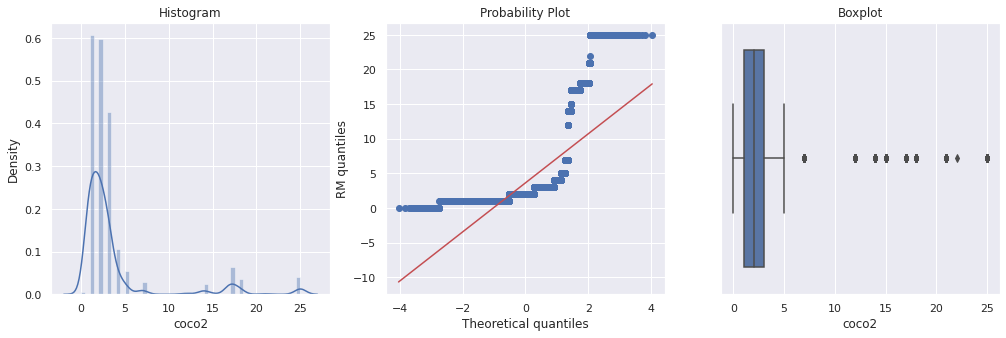

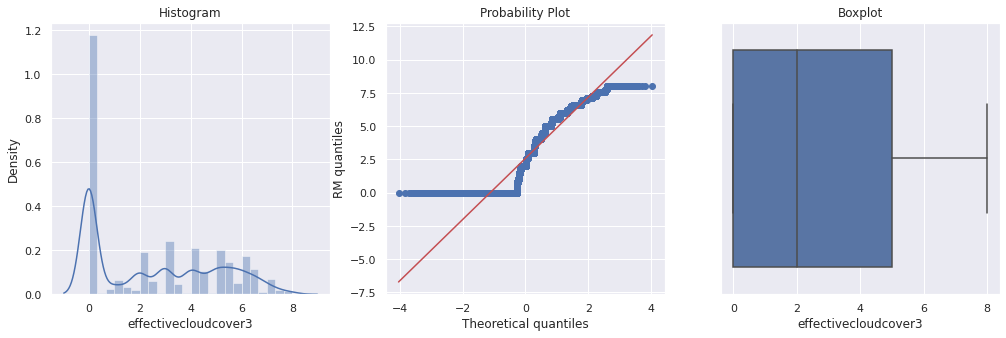

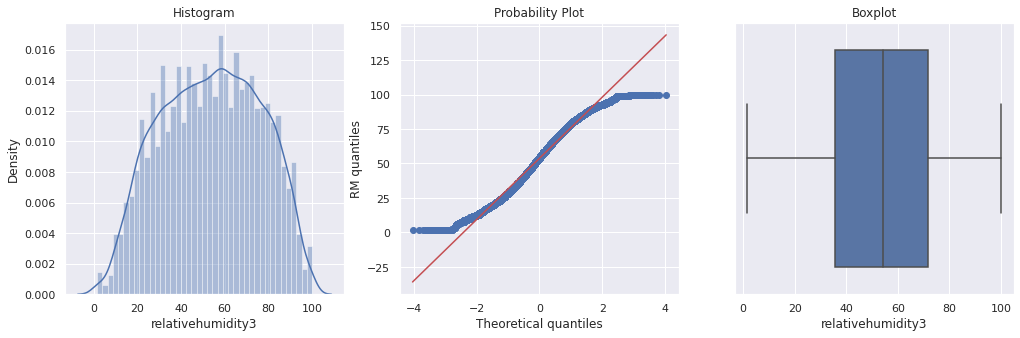

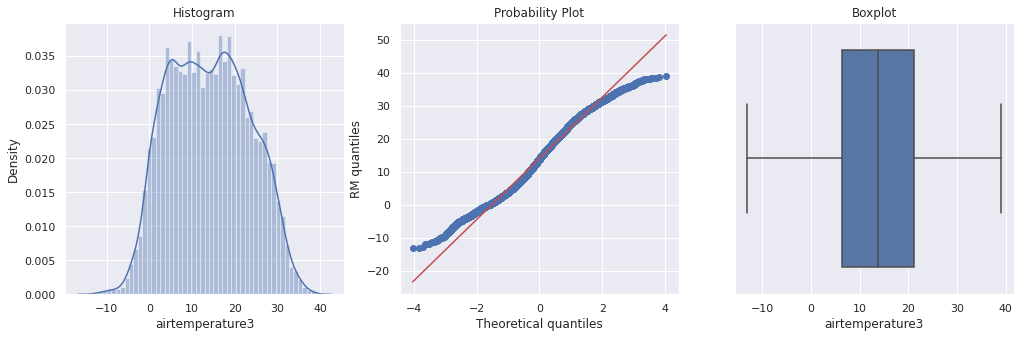

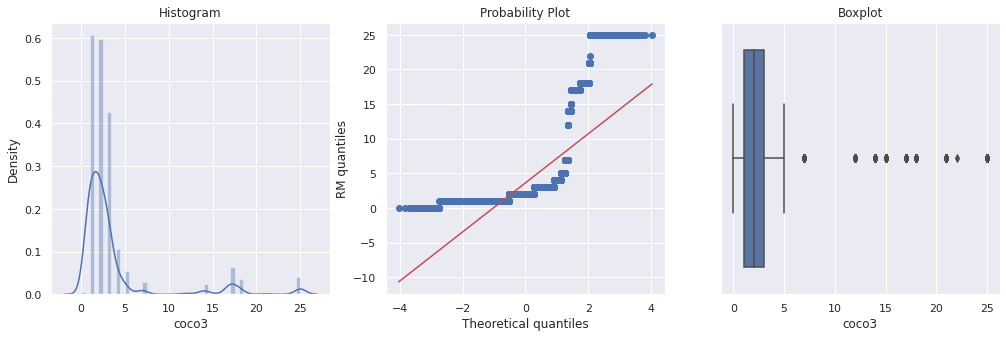

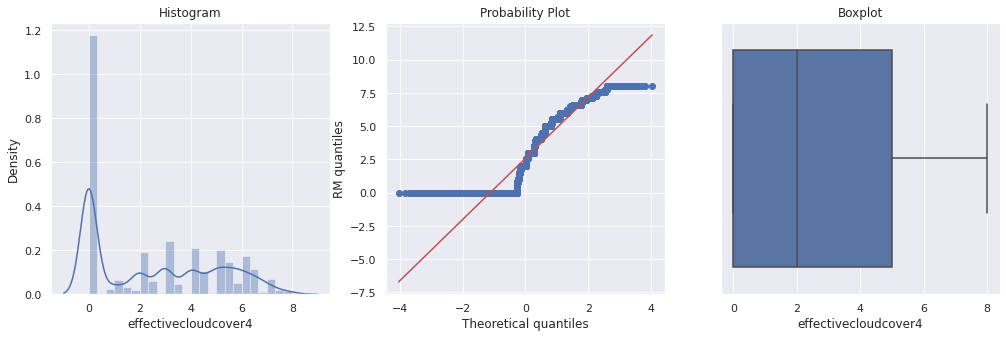

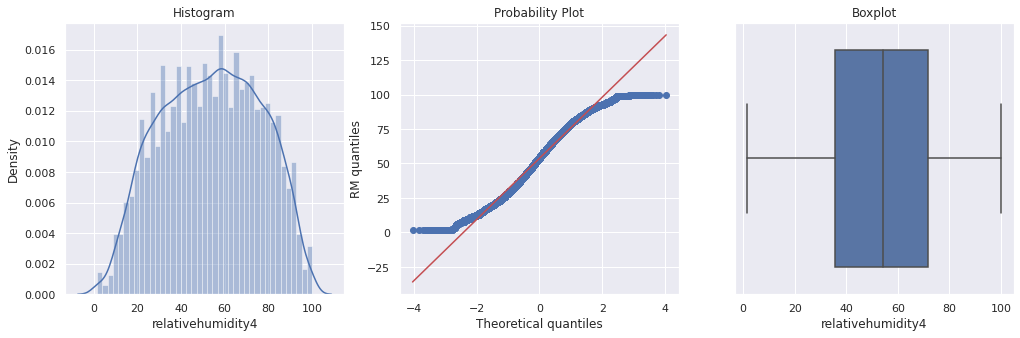

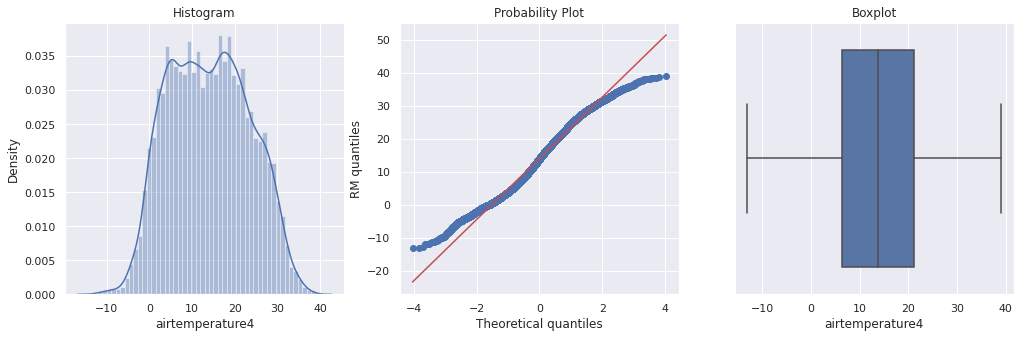

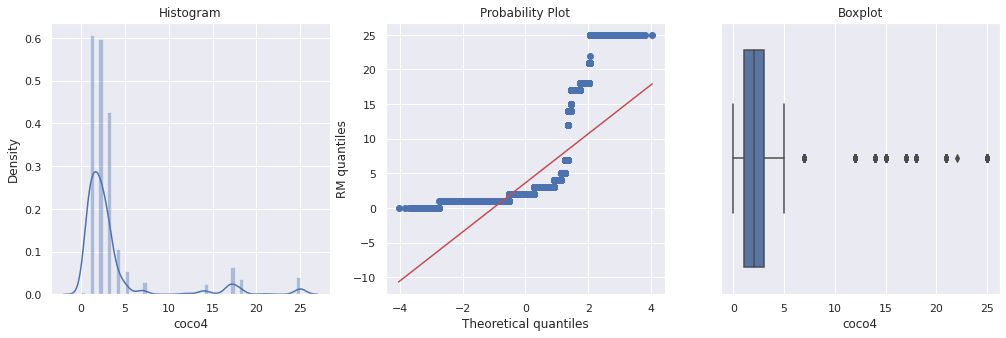

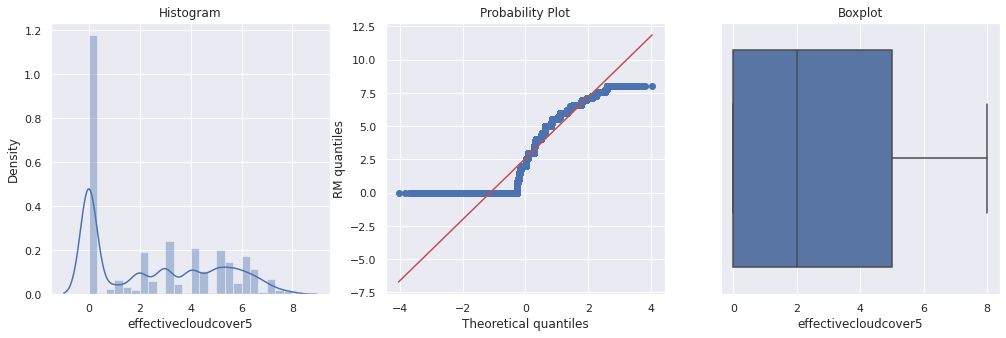

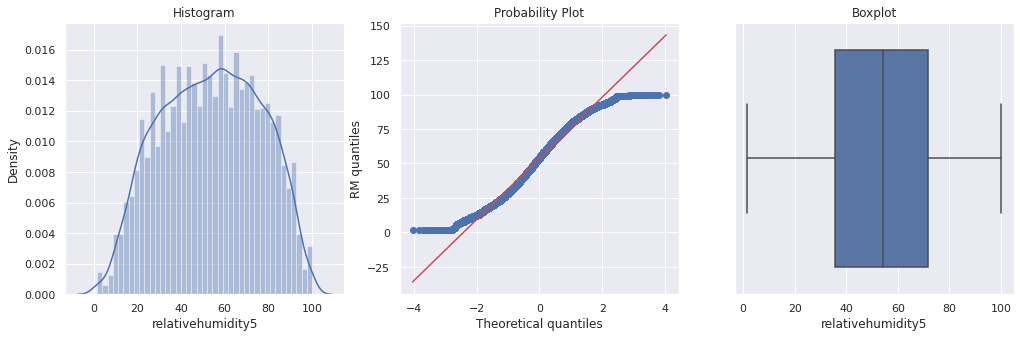

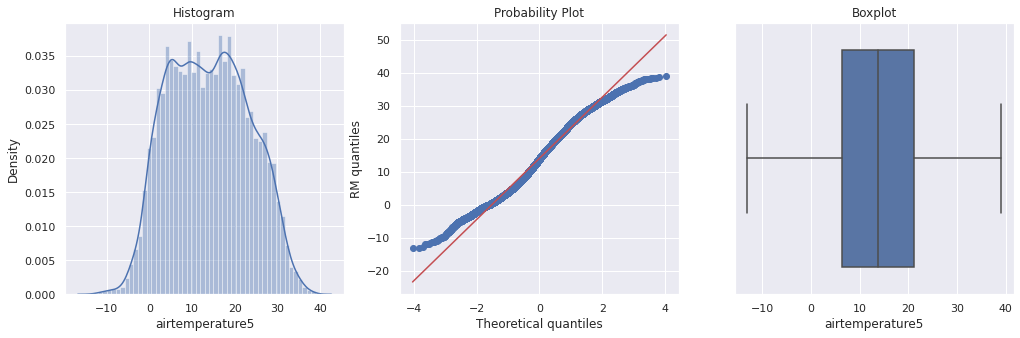

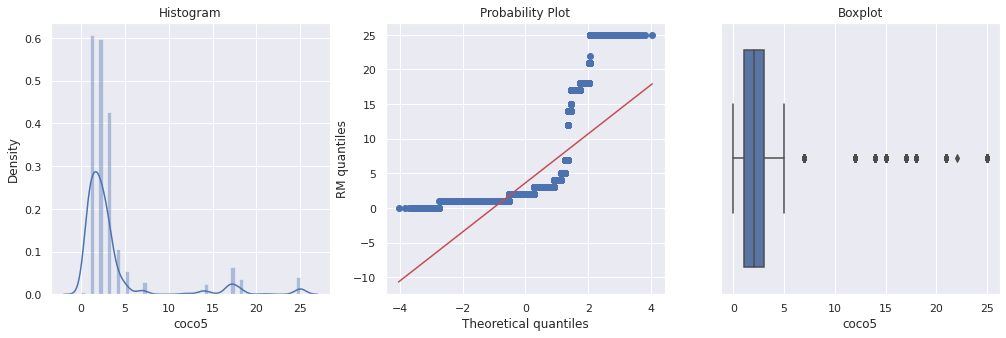

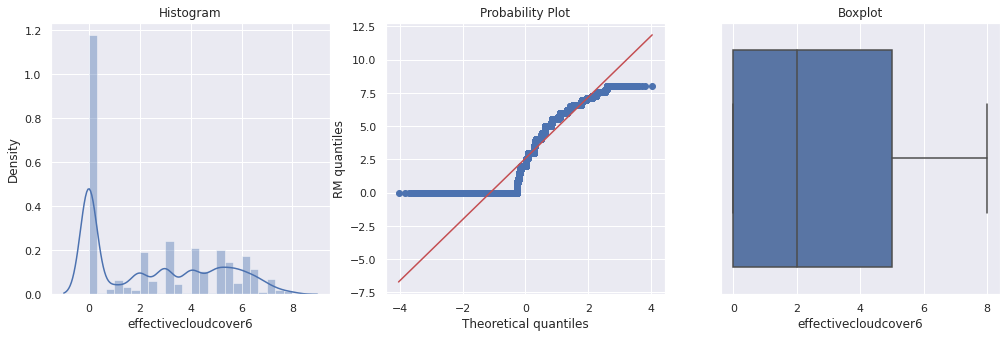

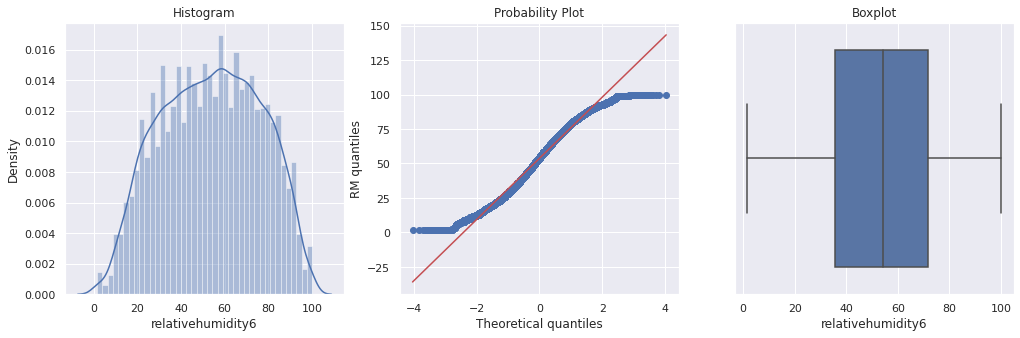

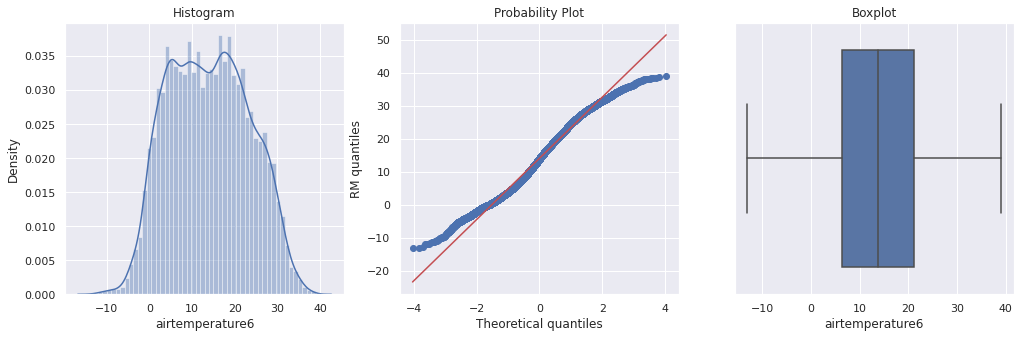

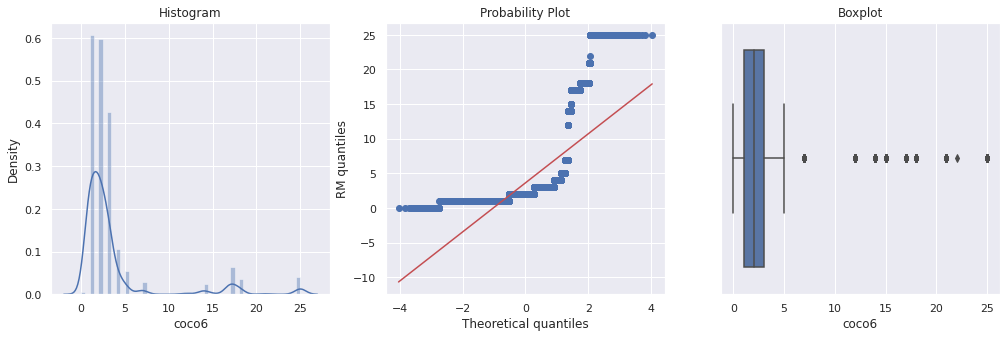

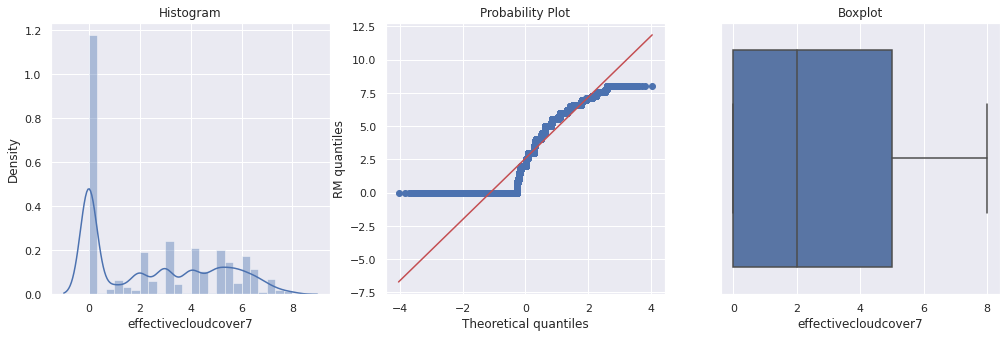

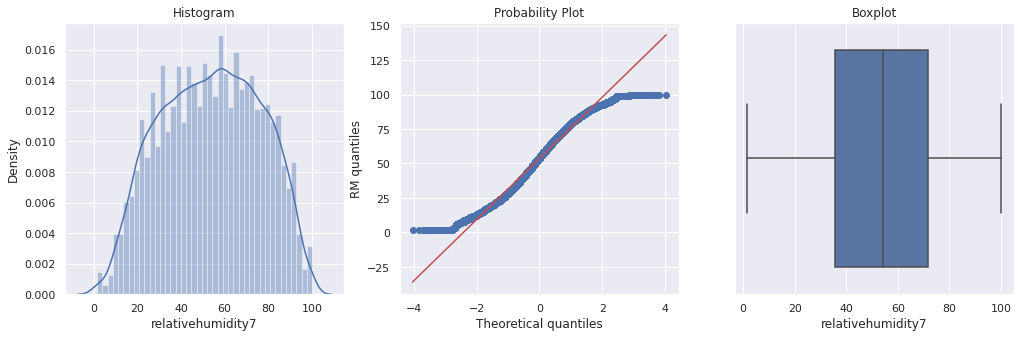

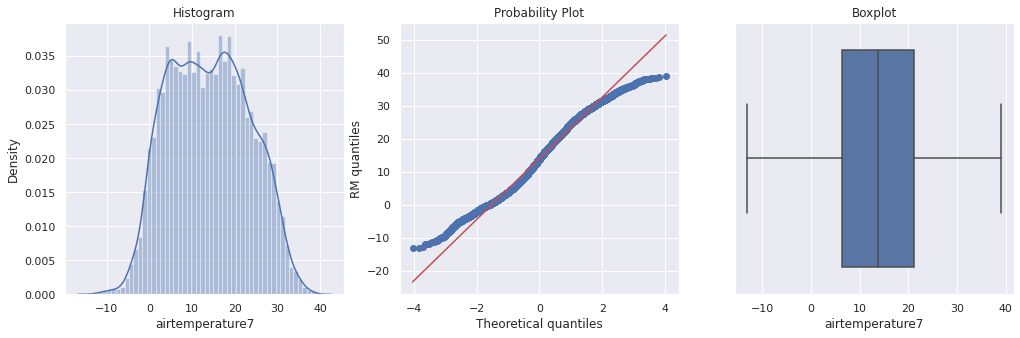

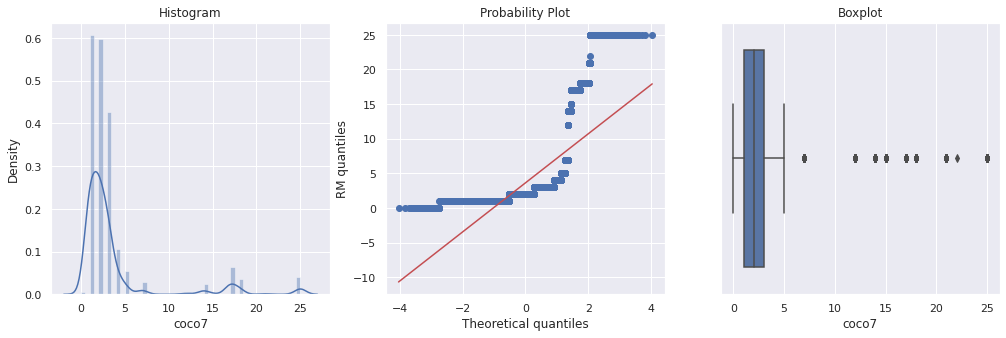

In [25]:
def box_dist_stats(df, variable):  
    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    sns.distplot(df[variable])
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[variable])
    plt.title('Boxplot')

    plt.show()
    
for col in data.select_dtypes(float).columns:
        box_dist_stats(data.dropna(),col)

In [26]:
data.corr().generation.sort_values().to_frame()

generation
rhum                 -0.701109
relativehumidity4    -0.645685
relativehumidity3    -0.643427
relativehumidity5    -0.616362
relativehumidity2    -0.606409
...                        ...
airtemperature3       0.508996
temp                  0.537419
tsun2                 0.849932
avg_month_hour_gen    0.937491
generation            1.000000

[68 rows x 1 columns]

<AxesSubplot:>

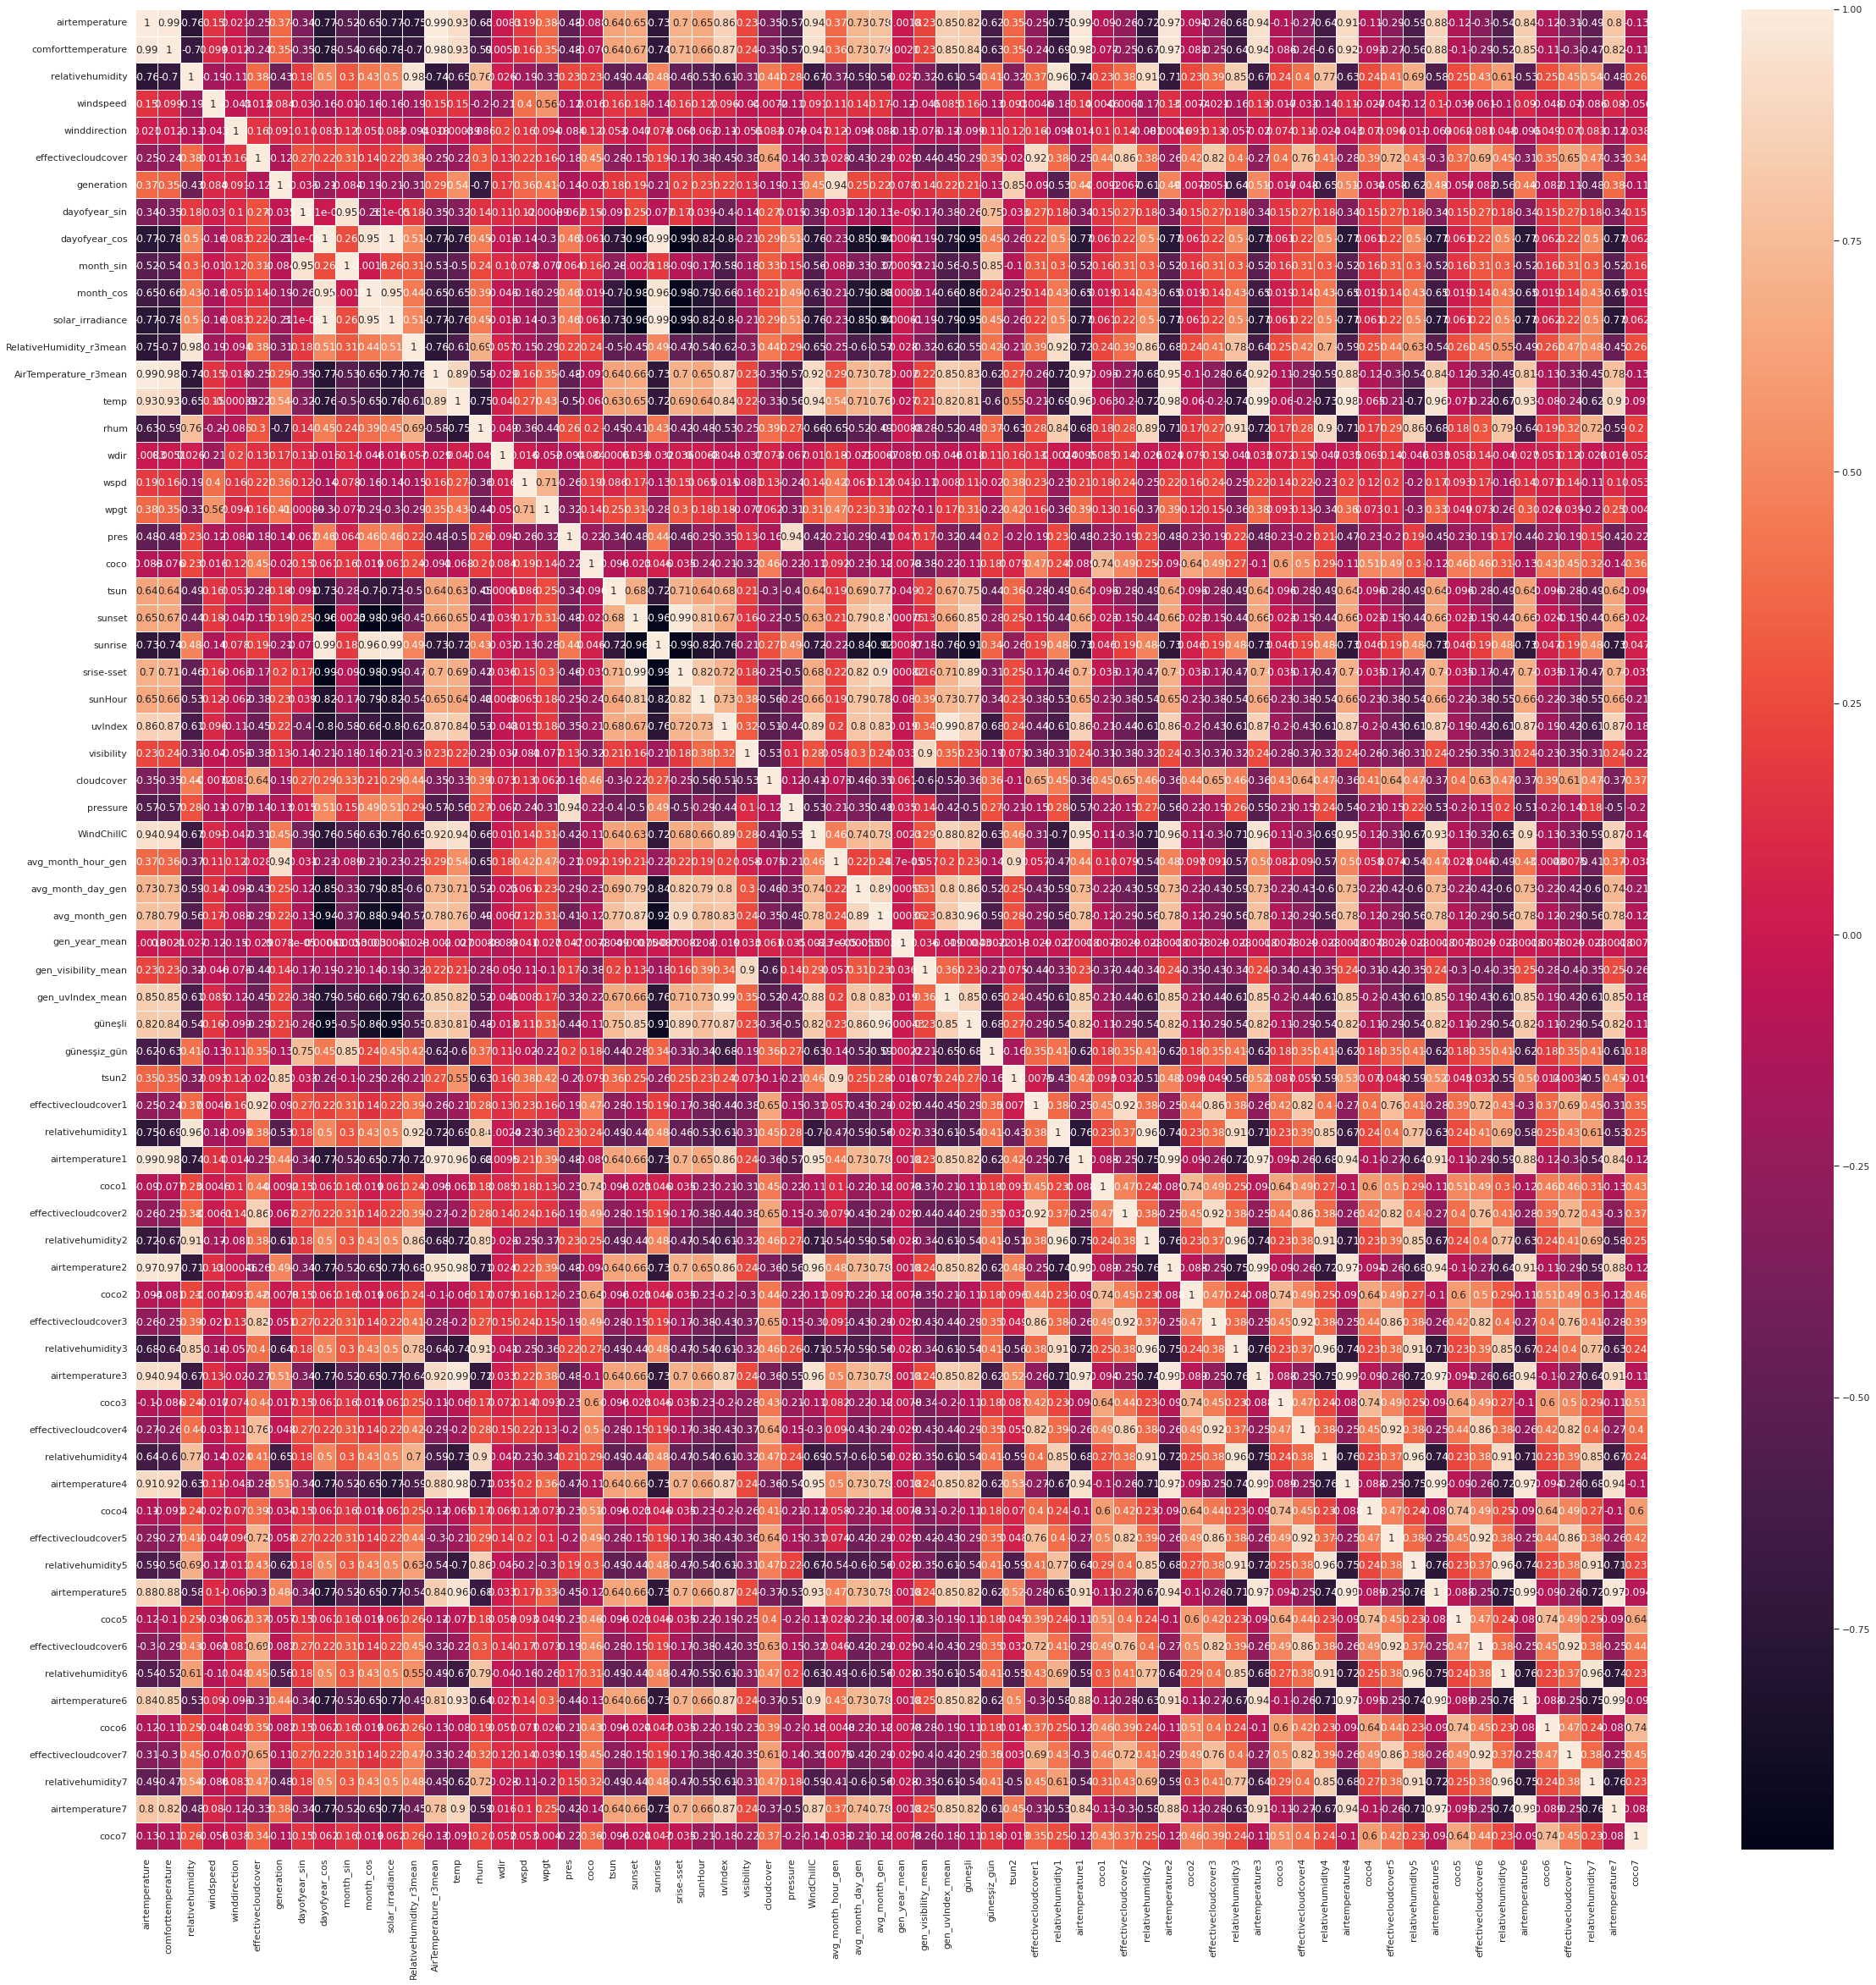

In [27]:
sns.set(rc={'figure.figsize':(40,40)})
sns.heatmap(data.corr(),annot=True,linewidths=.5)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 0 to 26303
Data columns (total 86 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 26304 non-null  datetime64[ns]
 1   airtemperature           26304 non-null  float64       
 2   comforttemperature       26304 non-null  float64       
 3   relativehumidity         26304 non-null  float64       
 4   windspeed                26304 non-null  float64       
 5   winddirection            26304 non-null  float64       
 6   wwcode                   26304 non-null  object        
 7   effectivecloudcover      26304 non-null  float64       
 8   generation               25560 non-null  float64       
 9   year                     26304 non-null  object        
 10  dayofmonth               26304 non-null  object        
 11  hour                     26304 non-null  object        
 12  month                    26304 n

In [29]:
#target variable disturibution
fig = ff.create_distplot([data[data.generation.notnull()][data.generation>5].generation],group_labels=["distplot"])
fig.show()
fig=px.box(data.generation, orientation="h",title='generation')
fig.show()

In [30]:
# some operation getting rid of outliers
outlier_bound=data.wspd.mean()+data.wspd.std()*2
data.loc[data.wspd>outlier_bound,'wspd']=outlier_bound
# -----------------------------------------------------------------------------------
outlier_bound=-2*data.comforttemperature.std()+data.comforttemperature.mean()
data.loc[data.comforttemperature<outlier_bound,'comforttemperature']=outlier_bound
# -----------------------------------------------------------------------------------
outlier_bound_low=-2*data.wpgt.std()+data.wpgt.mean()
outlier_bound_high=2*data.wpgt.std()+data.wpgt.mean()
data.loc[data.wpgt<outlier_bound_low,'wpgt']=outlier_bound_low
data.loc[data.wpgt>outlier_bound_high,'wpgt']=outlier_bound_high

data.set_index('datetime',inplace=True,drop=True)
data.uvIndex=data.uvIndex.astype(object)
data.visibility=data.visibility.map(lambda x: 2 if x<2 else x)
data.visibility=data.visibility.astype(object)

Dates train      : 2019-01-01 00:00:00 --- 2021-10-31 23:00:00  (n=24840)
Dates validacion : 2021-10-31 23:00:00 --- 2021-11-30 23:00:00  (n=721)
Dates test       : 2021-12-01 00:00:00 --- 2021-12-31 23:00:00  (n=744)
-------------------------------------------------------------------------------
data_train shape :(24840, 304), target_train shape :(24840,)
data_val shape   :(721, 304)  , target_val shape   :(721,)


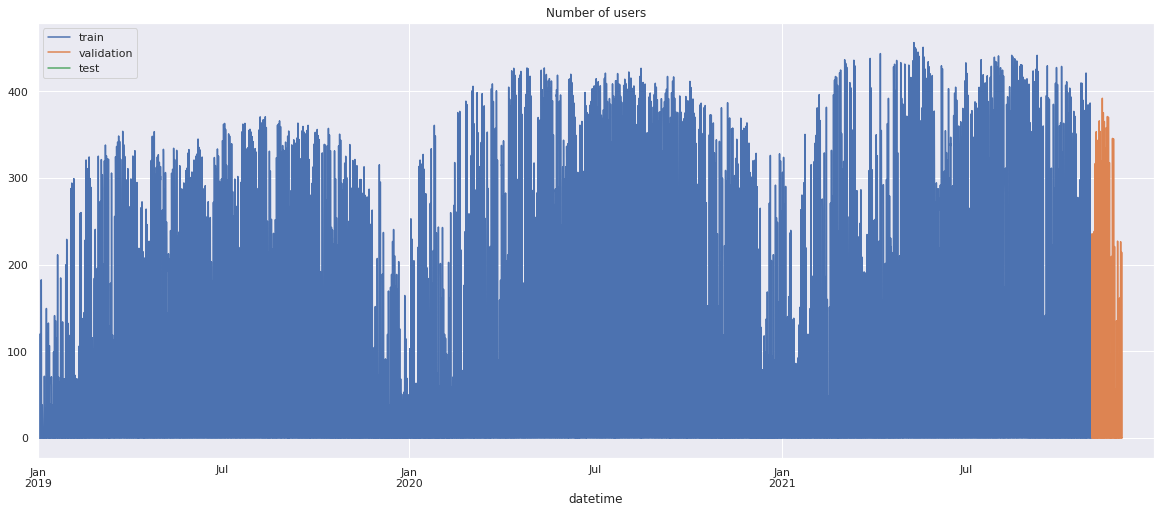

In [31]:
data2=data.copy()
data2.drop([
'date',
'windspeed',
'winddirection',
# 'gen_visibility_mean', 
# 'gen_uvIndex_mean',     
'coco',
'wwcode',
# 'comforttemperature',
# 'airtemperature',
# 'year',
'dayofmonth',
'tsun2',
'tsun',
# 'generation_label',
#     'effectivecloudcover'
'month',
'hour',
#     'rhum',               
# 'relativehumidity',     
# 'cloudcover',            
# 'pres',                 
# 'günesşiz_gün',      
# 'güneşli',
# 'effectivecloudcover' 
           ],axis=1,inplace=True)


data_dum=pd.get_dummies(data2,prefix=None,prefix_sep='_',drop_first=True)
# Split train-val-test
# ==============================================================================
end_train = '2021-10-31 23:00:00'
end_validation = '2021-11-30 23:00:00'
data_train = data_dum.loc[:end_train]
data_val   = data_dum.loc[end_train:end_validation:]
data_test  = data_dum['2021-12-01 00:00:00':]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# # Plot time series
# # ==============================================================================
fig, ax = plt.subplots(figsize=(20, 8))
data_train['generation'].plot(ax=ax, label='train')
data_val['generation'].plot(ax=ax, label='validation')
data_test['generation'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();
# ==============================================================================
target_train=data_train.generation.values
data_train.drop('generation',axis=1,inplace=True)
target_val=data_val.generation.values
data_val.drop('generation',axis=1,inplace=True)
data_test.drop('generation',axis=1,inplace=True)
sc=StandardScaler()
data_train=sc.fit_transform(data_train)
data_val=sc.transform(data_val)
data_test=sc.transform(data_test)
print('-------------------------------------------------------------------------------')
print(f'data_train shape :{data_train.shape}, target_train shape :{target_train.shape}')
print(f'data_val shape   :{data_val.shape}  , target_val shape   :{target_val.shape}')

# XGB model

## Model Tuning

In [32]:
def objective(trial,data=data_train,target=target_train):
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.009,0.01,0.012,0.014,0.016,0.018,0.001,0.1,0.5]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist'
                }
    
    xgb_tuned=xgb.XGBRegressor(**param)
    xgb_tuned.fit(data,target)
    xgb_pred=xgb_tuned.predict(data_test)
    rmse =np.sqrt(mean_squared_error(target_val,xgb_tuned.predict(data_val)))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-03-09 19:35:56,140] A new study created in memory with name: no-name-546b4c71-359a-49bd-a9e1-761b09e6fcad
[I 2022-03-09 19:36:30,914] Trial 0 finished with value: 16.267155353316337 and parameters: {'lambda': 0.014309310023659795, 'alpha': 0.08487863972517756, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 50}. Best is trial 0 with value: 16.267155353316337.
[I 2022-03-09 19:36:34,671] Trial 1 finished with value: 16.831830595720444 and parameters: {'lambda': 0.04672313622761632, 'alpha': 0.36982381702928246, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 247}. Best is trial 0 with value: 16.267155353316337.
[I 2022-03-09 19:36:49,983] Trial 2 finished with value: 16.423184609332377 and parameters: {'lambda': 0.9186145022664305, 'alpha': 0.2991143181667925, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'm

Number of finished trials: 80
Best trial: {'lambda': 0.3931052387433335, 'alpha': 0.3507094022440715, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 201}


In [33]:
study.best_trial.params

{'lambda': 0.3931052387433335,
 'alpha': 0.3507094022440715,
 'colsample_bytree': 0.7,
 'subsample': 0.7,
 'learning_rate': 0.014,
 'max_depth': 17,
 'random_state': 24,
 'min_child_weight': 201}

In [34]:
params= {
'n_estimators': 5000,
'tree_method':'gpu_hist',
'predictor': "gpu_predictor",
}
params.update(study.best_trial.params)

xgb_tuned=xgb.XGBRegressor( **params).fit(data_train,target_train) 


#model train
print('Model train')
print('rmse: ',np.sqrt(mean_squared_error(target_train,xgb_tuned.predict(data_train))))
print('r2: ',r2_score(target_train,xgb_tuned.predict(data_train)))


print('Model valid')
print('rmse :',np.sqrt(mean_squared_error(target_val,xgb_tuned.predict(data_val))))
print('r2 :',r2_score(target_val,xgb_tuned.predict(data_val)))
print('-----------------------------------------------------------------------')
xgb_pred=xgb_tuned.predict(data_test)
xgb_pred=pd.Series(xgb_pred)
print(xgb_pred.min())
print(xgb_pred.max())
print('-----------------------------------------------------------------------')
print(xgb_pred[xgb_pred>0].mean())
print('-----------------------------------------------------------------------')
xgb_pred[xgb_pred<0]=0
print(xgb_pred.mean())

Model train
rmse:  5.734121653249971
r2:  0.9979470413905972
Model valid
rmse : 15.514987025587955
r2 : 0.9802057603164418
-----------------------------------------------------------------------
-8.987846374511719
333.5903625488281
-----------------------------------------------------------------------
63.862548828125
-----------------------------------------------------------------------
41.8025016784668


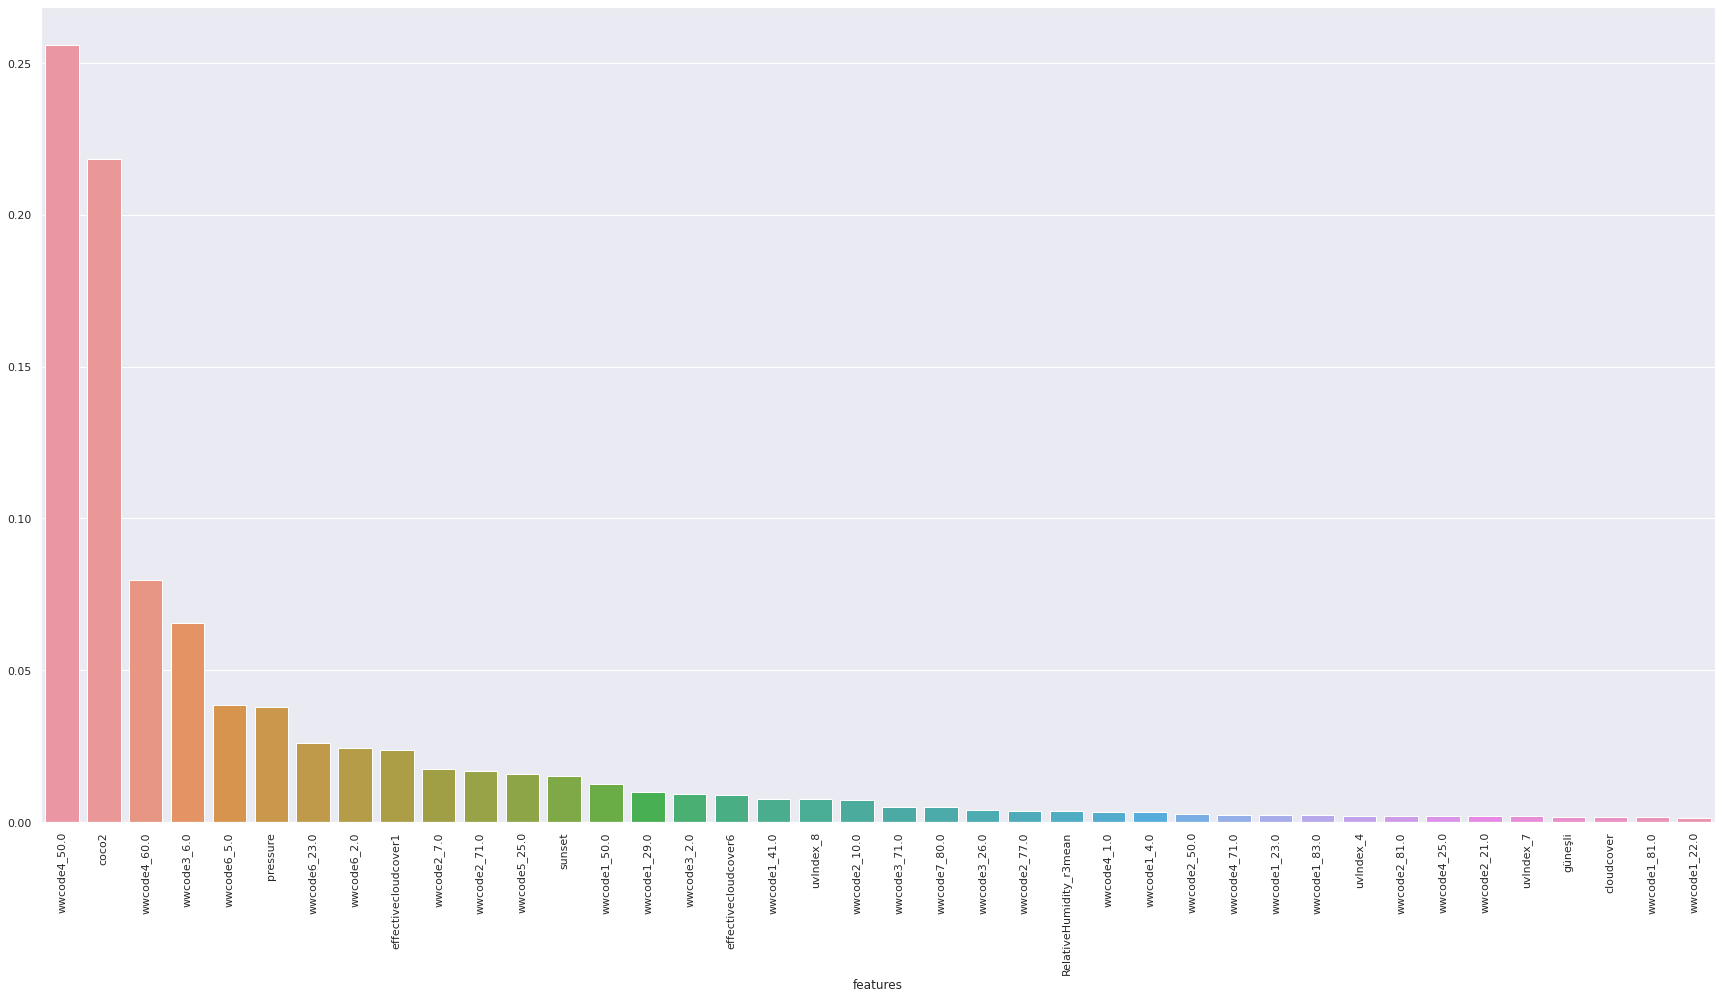

In [35]:
cols=list(set(data_dum.columns)-set(generation))
dum=pd.DataFrame(data={'features':cols,'importances_rate':xgb_tuned.feature_importances_}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features[:40],y=dum.importances_rate[:40].values,)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

# Save Result

In [36]:
sample_submission=pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
sample_submission['date']=pd.to_datetime(sample_submission['DateTime'])
sample_submission['hour']=sample_submission['date'].dt.hour
sample_submission['Generation']=xgb_pred.values
sample_submission.loc[(sample_submission.hour<=5)|(sample_submission.hour>=20),'Generation']=0
sample_submission.drop(['date','hour'],axis=1,inplace=True)
sample_submission=sample_submission.set_index('DateTime')
sample_submission.to_csv('/kaggle/working/result64.csv')